# About this Notebook
__`Exploratory data analysis &  Discussion of Challenges`__

This notebook describes our exploration of datasets and understanding of current delay pattern and its correlationship with visualization. We have checked each dataset's status by scanning the total number of rows, columns and missing value. Also, we checked the delay staus by timeseries, different pattern between airline carrier, and lastly correlationship.

# Libraries

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import ast
import os, sys
import airporttime
from datetime import datetime, timedelta, timezone

from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, array
from pyspark.sql.functions import split, col
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, max

# ML models
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

# Dimension reduction
from pyspark.ml.feature import PCA

# Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Visualization
import matplotlib.pyplot as pl

from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer, Imputer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import MulticlassMetrics


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
from pyspark import SparkContext
from pyspark import SQLContext

from pyspark.sql.functions import *
#from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline

from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [0]:
# configuration 
blob_container = "team18" # The name of your container created in https://portal.azure.com
storage_account = "team18" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261team18" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261team18key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"
blob_url


# SAS Token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

Out[7]: 'wasbs://team18@team18.blob.core.windows.net'

# Local fuctions

It was important us to scan null value status for analysis. However, it was hard to scan especially if we have this kind of big data. Therefore,  we developed the local function to explore the null dataset

In [0]:
def empty_to_Null(df):
    """ Helper function to fill in missing values with Null. 
    """
    df2=df.select([F.when(F.col(c)=="",None).otherwise(F.col(c)).alias(c) for c in df.columns])
    return df2


def qualified_features(df, threshold):
    """ Helper function takes a dataframe, returns a list of column names where each column has missing values lower than 50% out of the whole dataset.
    Input: Dataframe
    Output: A List of column names
    """
    lst= []
    pd = df.toPandas()
    for c in pd.columns:
        if pd[c][0]<float(threshold):
            lst.append(c)
        return lst


def pct_null(df):
    """ Helper function takes a dataframe, returns a list of column names where each column has missing values lower than 50% out of the whole dataset.
    Input: Dataframe
    Output: Dataframe with 1 row showing percentage of null values
    """
    sum_df = df.select([(F.count(F.when(F.col(c).isNull(), c))/F.count(F.lit(1))).alias(c) for c in df.columns])
    return sum_df


# Understanding Datasets

### 1. Global Airport Data

This data simply shows the basic information of airport. We are using 'ShortName' column to join weather data later. 
It has 9300 records with 8 columns including including shortname, code, country etc. It has the information of 229 countries.
Especially, USA alone it has 552 airport information.

In [0]:
#Read GlobalAirport data 
df_airport = spark.read.option("header",True).csv(blob_url+'/airlineData/GlobalAirport.csv')
display(df_airport)

ShortName Code Name City Country Elevation Longtitude Latitude AYGA GKA GOROKA GOROKA PAPUA NEW GUINEA 1610 -6.082 145.392 AYLA LAE N/A LAE PAPUA NEW GUINEA 0 0 0 AYMD MAG MADANG MADANG PAPUA NEW GUINEA 7 -5.207 145.789 AYMH HGU MOUNT HAGEN MOUNT HAGEN PAPUA NEW GUINEA 1643 -5.826 144.296 AYNZ LAE NADZAB NADZAB PAPUA NEW GUINEA 73 -6.57 146.726 AYPY POM PORT MORESBY JACKSONS INTERNATIONAL PORT MORESBY PAPUA NEW GUINEA 45 -9.443 147.22 AYRB RAB N/A RABAUL PAPUA NEW GUINEA 0 0 0 AYWK WWK WEWAK INTERNATIONAL WEWAK PAPUA NEW GUINEA 6 -3.584 143.669 BGAM N/A N/A ANGMAGSSALIK GREENLAND 0 0 0 BGAS N/A N/A ANGISSOQ GREENLAND 0 0 0 BGAT N/A N/A APUTITEQ GREENLAND 0 0 0 BGBW UAK NARSARSUAQ NARSSARSSUAQ GREENLAND 35 61.161 -45.427 BGCH JCH N/A CHRISTIANSHAAB GREENLAND 0 0 0 BGCO N/A NERLERIT INAAT CONSTABLE PYNT NERLERIT INAAT GREENLAND 14 70.739 -22.646 BGDB N/A N/A DANEBORG GREENLAND 0 0 0 BGDH N/A N/A DANMARKSHAVN GREENLAND 0 0 0 BGDU N/A N/A DUNDAS GREENLAND 0 0 0 BGEM JEG N/A EGEDESMINDE GREENLAND 0 0 0 BGFD N/A N/A FREDERIKSDAL GREENLAND 0 0 0 BGFH JFR N/A FREDERIKSHAAB GREENLAND 0 0 0 BGGD JGR N/A GRONNEDAL GREENLAND 0 0 0 BGGH GOH NUUK GODTHAAB GREENLAND 87 64.191 -51.678 BGGN JGO N/A GODHAVN GREENLAND 0 0 0 BGHB JHS N/A HOLSTEINSBORG GREENLAND 0 0 0 BGIS N/A N/A ISORTOQ GREENLAND 0 0 0 BGIT N/A N/A IVIGTUT GREENLAND 0 0 0 BGJH JJU N/A JULIANEHAAB GREENLAND 0 0 0 BGJN JAV JACOBSHAVN JAKOBSHAVN GREENLAND 34 69.233 -51.067 BGKD N/A N/A KAP DAN GREENLAND 0 0 0 BGKK KUS KULUSUK KULUSUK GREENLAND 34 65.583 -37.15 BGKM N/A N/A KUNGMIUT GREENLAND 0 0 0 BGKT N/A N/A KAP TOBIN GREENLAND 0 0 0 BGMV N/A N/A MESTERS VIG GREENLAND 0 0 0 BGNN JNN N/A NANORTALIK GREENLAND 0 0 0 BGNS JNS N/A NARSSAQ GREENLAND 0 0 0 BGOS N/A N/A ORSSUIORSSUAQ GREENLAND 0 0 0 BGPC N/A N/A PRINS CHRISTIAN SUND GREENLAND 0 0 0 BGRS N/A N/A RAVNS STORO GREENLAND 0 0 0 BGSC N/A N/A SCORESBYSUND GREENLAND 0 0 0 BGSF SFJ KANGERLUSSUAQ SONDRE STROMFJORD SONDRESTROM GREENLAND 51 67.017 -50.689 BGSG N/A N/A SERMILIGAO GREENLAND 0 0 0 BGST JSU N/A SUKKERTOPPEN GREENLAND 0 0 0 BGTL THU THULE AIR BASE THULE GREENLAND 77 76.531 -68.703 BGTM N/A N/A TINGMIARMIUT GREENLAND 0 0 0 BGTN N/A N/A TINITEQILAQ GREENLAND 0 0 0 BGUM N/A N/A UMANAK GREENLAND 0 0 0 BGUP JUV N/A UPERNAVIK GREENLAND 0 0 0 BIAR AEY AKUREYRI AKUREYRI ICELAND 2 65.66 -18.072 BIBL N/A N/A BLONDUOS ICELAND 0 0 0 BIDV N/A N/A DJUOIVOGUR ICELAND 0 0 0 BIEG EGS EGILSSTADIR EGILSSTADIR ICELAND 24 65.283 -14.401 BIFM N/A N/A FAGURHOLSMYRI ICELAND 0 0 0 BIGR GRY N/A GRIMSEY ICELAND 0 0 0 BIHN HFN HORNAFJORDUR HOFN ICELAND 8 64.296 -15.227 BIHU HZK HUSAVIK HUSAVIK ICELAND 14 65.952 -17.426 BIIS IFJ ISAFJORDUR ISAFJORDUR ICELAND 3 66.058 -23.135 BIKF KEF KEFLAVIK NAS KEFLAVIK ICELAND 53 63.985 -22.606 BIKP OPA KOPASKER KOPASKER ICELAND 7 66.314 -16.461 BIKR SAK N/A SAUDARKROKUR ICELAND 0 0 0 BINF NOR N/A NORDFJORDUR ICELAND 0 0 0 BIPA PFJ PATREKSFJORDUR PATREKSFJORDUR ICELAND 4 65.556 -23.965 BIRG RFN N/A RAUFARHOFN ICELAND 0 0 0 BIRK RKV REYKJAVIK REYKJAVIK ICELAND 15 64.13 -21.941 BISI SIJ SIGLUFJORDHUR SIGLUFJORDUR ICELAND 4 66.133 -18.917 BISS N/A N/A SANDSKEID ICELAND 0 0 0 BIST N/A N/A STYKKISHOLMUR ICELAND 0 0 0 BITE TEY N/A THINGEYRI ICELAND 0 0 0 BITH THO N/A THORSHOFN ICELAND 0 0 0 BIVM VEY VESTMANNAEYJAR VESTMANNAEYJAR ICELAND 100 63.424 -20.279 BIVO VPN N/A VOPNAFJORDUR ICELAND 0 0 0 BZGD N/A N/A GODLEY NEW ZEALAND 0 0 0 CUAP N/A N/A ACTIVE PASS CANADA 0 0 0 CUHA YQC N/A QUAQTAQ CANADA 0 0 0 CUQC N/A N/A STIRLING CANADA 0 0 0 CUUP N/A N/A OTTAWA CANADA 0 0 0 CWBF N/A N/A BATTLE HARBOUR CANADA 0 0 0 CWHJ N/A N/A HOLBERG CANADA 0 0 0 CWMK N/A N/A SIMCOE CANADA 0 0 0 CWMN N/A N/A MOUNT FOREST CANADA 0 0 0 CWOH N/A N/A SAINTE AGATHE CANADA 0 0 0 CWPC N/A N/A PINCHER CREEK CANADA 0 0 0 CWPO N/A N/A PILOT MOUNT CANADA 0 0 0 CWVA N/A N/A BONAVISTA CANADA 0 0 0 CYAB YAB N/A ARCTIC BAY CANADA 0 0 0 CYAJ N/A N/A KOMAKUK CANADA 0 0 0 CYAL YAL N/A ALERT BAY CANADA 0 0 0 CYAM YAM SAULT STE MARIE SAULT SAINTE MARIE CANADA 

In [0]:
print("Total Record: " + str(df_airport.count()))
print("Total number of column : " + str(len(df_airport.columns)))
df2=df_airport.select(countDistinct("Country"))
print("Distinct Count of Country: " + str(df2.collect()[0][0]))
usa=df_airport.filter(col("Country")=='USA').count()
print("The number of airport in USA: " + str(usa))

Total Record: 9300
Total number of column : 8
Distinct Count of Country: 229
The number of airport in USA: 552

### 2.  Flight Data

This data is subset of the passenger flight's on-time performance data taken from the TranStats data collection available from the U.S. Department of Transportation (DOT). For our given dataset, the total record is 63,493,682. However, we found out 31,746,841 records are duplicateds (These are gotten rid from feature engineering stage later). It has 109 columns and information we can attain from this table is below.


* __Flight related__ : 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM', 'TAIL_NUM' etc.
* __Date related__ : 'YEAR','QUATER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK' etc.
* __Flight Time realted__ : 'CRS_DEP_TIME','DEP_TIME', 'CRS_ARR_TIME','TAXI_OUT' etc.
* __Delay Reason__ :  'CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY' etc.
* __Flag of Dealy__: 'DEP_DEL15' 
* __Flag of Cancellation__: 'CANCELLED'

Half of features are all null (Fig 1.) . Therefore, we needed to filter out key features from join stage.

In [0]:
# Load Flights Data# 
df_airlines = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*")

In [0]:
df2= df_airlines.count()
print("Total Record of data: " + str(df2))

df2= len(df_airlines.columns)
print("Total column of data: " + str(df2))

#  duplicated rows 
df_airlines_drop=df_airlines.drop_duplicates()
gap=df_airlines.count()-df_airlines_drop.count()
print("The number of duplicated rows is: " + str(gap))

Total Record of data: 63493682
Total column of data: 109
The number of duplicated rows is: 31746841

In [0]:
from collections import defaultdict
# Convert Integer Type to Double Type 

data_types = defaultdict(list)
for entry in df_airlines_drop.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)
      
# column type 
from pyspark.sql.types import StringType, DoubleType

# get string
str_cols = [f.name for f in df_airlines.schema.fields if isinstance(f.dataType, StringType)]
print("the number of string type : ", len(str_cols))
# ['colc']

# or double
dbl_cols = [f.name for f in df_airlines.schema.fields if isinstance(f.dataType, DoubleType)]
print("the number of double type : ", len(dbl_cols))
# ['colb']

the number of string type : 38
the number of double type : 32

In [0]:
# get the percentage of null value 
df_wNull = empty_to_Null(df_airlines_drop)
sum_null = pct_null(df_wNull)
display(sum_null)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.002283282295709359 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.014877700745091456 0.015034440749553632 0.015034440749553632 0.015034440749553632 0.015034440749553632 0.0 0.015321744925739225 0.015321587429754034 0.015810202974210884 0.015810202974210884 0.0 0.015810139975816807 0.01797470179788912 0.01797470179788912 0.01797470179788912 0.01797470179788912 0.0 0.0 0.9845670629087159 0.0 5.1658683142678665E-6 0.017892866883983827 0.017892866883983827 0.0 0.0 0.0 0.8173325654669074 0.8173325654669074 0.8173325654669074 0.8173325654669074 0.8173325654669074 0.9935974102116176 0.9935974732100117 0.9935974732100117 9.44975911146561E-8 0.9975396607177388 0.997917336090227 0.99791730459103 0.9975400387081033 0.9974283740546028 0.9974283740546028 0.9974283740546028 0.9974284055537999 0.9974283740546028 0.9974283740546028 0.997904137926668 0.9979040749282739 0.9999783600516348 0.9999782340548465 0.9999782340548465 0.9999783600516348 0.9999783600516348 0.9999783600516348 0.9999912747224204 0.9999912747224204 0.9999997795056207 0.9999997795056207 0.9999997795056207 0.9999997795056207 0.9999997795056207 0.9999997795056207 0.999999968500803 0.999999968500803 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0

In [0]:
# Null Status 
null_df = sum_null.toPandas()
null_plot_data = null_df.T.sort_values(null_df.index[-1], ascending=False)
null_plot_data.rename({0: '% missing'}, axis=1, inplace=True)
# sorting 
null_plot_data[0:30]

Out[311]:

% missing 
 
 
 
 
 DIV5_TAIL_NUM 
 1.000000 
 
 
 DIV4_TAIL_NUM 
 1.000000 
 
 
 DIV4_AIRPORT 
 1.000000 
 
 
 DIV4_AIRPORT_ID 
 1.000000 
 
 
 DIV4_AIRPORT_SEQ_ID 
 1.000000 
 
 
 DIV4_WHEELS_ON 
 1.000000 
 
 
 DIV4_TOTAL_GTIME 
 1.000000 
 
 
 DIV4_LONGEST_GTIME 
 1.000000 
 
 
 DIV4_WHEELS_OFF 
 1.000000 
 
 
 DIV5_AIRPORT 
 1.000000 
 
 
 DIV5_AIRPORT_ID 
 1.000000 
 
 
 DIV5_AIRPORT_SEQ_ID 
 1.000000 
 
 
 DIV5_WHEELS_ON 
 1.000000 
 
 
 DIV5_TOTAL_GTIME 
 1.000000 
 
 
 DIV5_LONGEST_GTIME 
 1.000000 
 
 
 DIV5_WHEELS_OFF 
 1.000000 
 
 
 DIV3_TAIL_NUM 
 1.000000 
 
 
 DIV3_WHEELS_OFF 
 1.000000 
 
 
 DIV3_AIRPORT 
 1.000000 
 
 
 DIV3_WHEELS_ON 
 1.000000 
 
 
 DIV3_AIRPORT_ID 
 1.000000 
 
 
 DIV3_AIRPORT_SEQ_ID 
 1.000000 
 
 
 DIV3_TOTAL_GTIME 
 1.000000 
 
 
 DIV3_LONGEST_GTIME 
 1.000000 
 
 
 DIV2_TAIL_NUM 
 0.999991 
 
 
 DIV2_WHEELS_OFF 
 0.999991 
 
 
 DIV2_AIRPORT 
 0.999978 
 
 
 DIV2_LONGEST_GTIME 
 0.999978 
 
 
 DIV2_TOTAL_GTIME 
 0.999978 
 
 
 DIV2_WHEELS_ON 
 0.999978

Out[312]: Out[312]: Out[312]: Out[312]: Out[312]: Out[312]:

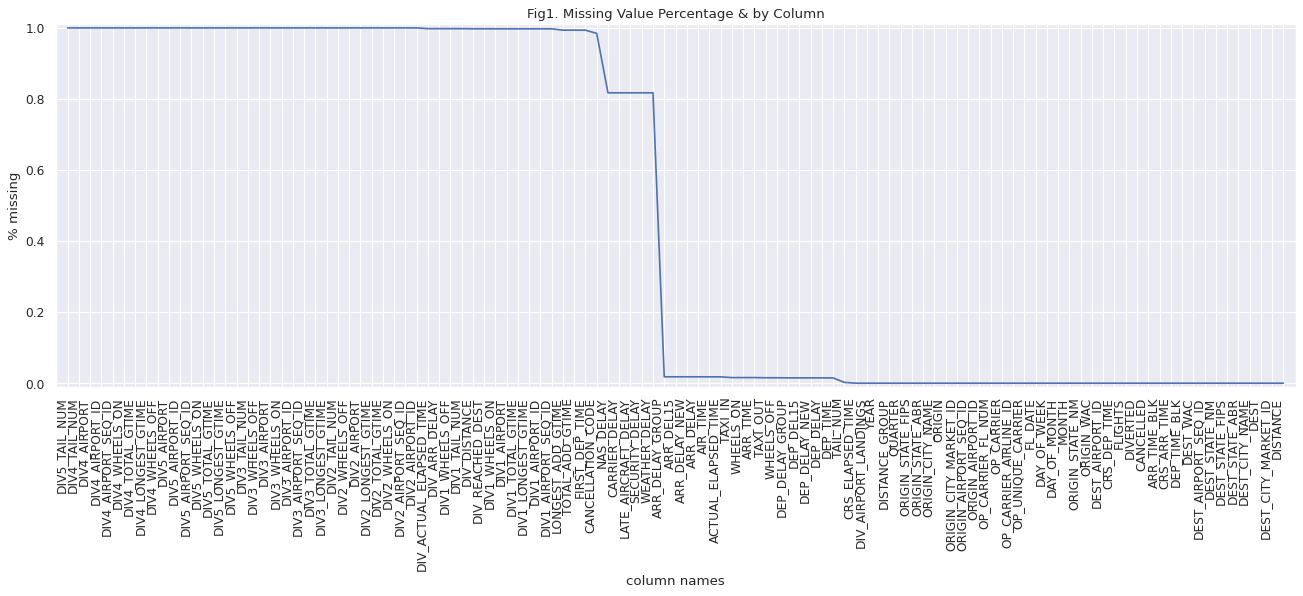

Text(0.5, 1.0, 'Fig1. Missing Value Percentage & by Column')

In [0]:
# null value graph 
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)
plt.plot(null_plot_data.index, null_plot_data['% missing'])
plt.xticks(null_plot_data.index, null_plot_data.index, rotation=90,
horizontalalignment='right')
plt.ylabel('% missing')
plt.xlabel('column names')
plt.margins(0.01)
plt.title('Fig1. Missing Value Percentage & by Column')
plt.show()

## 3. Station Data

This data show the weather station ID information. Each Station has its geographic information (lat,lon) along with its neighboring airport. We also have the geographic location of airports too. This information is important because we need to find out the station ID of nearest origion and arrival airports. There are distance information of each station to each airport. (1 airport->2229 airports). With this distance, we are able to identify the nearest weather station to airport.

In [0]:
#get station data
df_stations = spark.read.parquet("/mnt/mids-w261/datasets_final_project/stations_data/*")
display(df_stations)

usaf wban station_id lat lon neighbor_id neighbor_name neighbor_state neighbor_call neighbor_lat neighbor_lon distance_to_neighbor 690020 93218 69002093218 36.0 -121.233 69002093218 JOLON HUNTER LIGGETT MIL RES CA KHGT 36.0 -121.233 0.0 690020 93218 69002093218 36.0 -121.233 69007093217 FRITZSCHE AAF CA KOAR 36.683 -121.767 55.73024537916726 690020 93218 69002093218 36.0 -121.233 69014093101 EL TORO MCAS CA KNZJ 33.667 -117.733 255.49106220353934 690020 93218 69002093218 36.0 -121.233 70027127506 BARROW POINT BARROW AK KPBA 71.333 -156.65 2750.4353299559803 690020 93218 69002093218 36.0 -121.233 70045027512 LONELY AK LNI 70.917 -153.25 2676.3554370627153 690020 93218 69002093218 36.0 -121.233 70063027403 OLIKTOK POW 2 AK POLI 70.5 -149.883 2604.050248854232 690020 93218 69002093218 36.0 -121.233 70063526465 GALBRAITH LAKE AIRPORT AK PAGB 68.479 -149.49 2490.9756094472277 690020 93218 69002093218 36.0 -121.233 70063627405 PRUDHOE BAY AK PAUD 70.25 -148.333 2568.180281844432 690020 93218 69002093218 36.0 -121.233 70104626418 CENTRAL AIRPORT AK PACE 65.567 -144.765 2254.5584891291946 690020 93218 69002093218 36.0 -121.233 70119526625 SHISHMAREF/NEW AIRPORT AK PASH 66.25 -166.089 2743.6881828292408 690020 93218 69002093218 36.0 -121.233 70121326638 POINT LAY LIZ 2 AK PIZ 69.733 -163.017 2796.6187763021226 690020 93218 69002093218 36.0 -121.233 70148626642 KIVALINA AIRPORT AK PAVL 67.732 -164.548 2755.8847615355235 690020 93218 69002093218 36.0 -121.233 70162026508 UMIAT AK PAUM 69.367 -152.133 2580.421414177685 690020 93218 69002093218 36.0 -121.233 70171900490 SHUNGNAK AIRPORT AK PAGH 66.888 -157.162 2560.459862643483 690020 93218 69002093218 36.0 -121.233 70174526480 CHANDALAR LAKE AIRPORT AK PALR 67.511 -148.493 2423.3408124753164 690020 93218 69002093218 36.0 -121.233 70179326524 MANLEY HOT SPRINGS AK PAML 64.999 -150.638 2336.6091618691917 690020 93218 69002093218 36.0 -121.233 70199526628 CAPE DARBY REMOT COM OUTLT AK PAGL 64.55 -163.007 2610.7849480759573 690020 93218 69002093218 36.0 -121.233 70206026632 NORTHEAST CAPE AK KOHC 63.317 -168.967 2740.2899674712785 690020 93218 69002093218 36.0 -121.233 70222326602 KOYUK AIRPORT AK PAKK 64.935 -161.155 2576.6261990332778 690020 93218 69002093218 36.0 -121.233 70231226555 FAREWELL LAKE SEAPLANE BASE AK PAFK 62.543 -153.623 2293.7430034471354 690020 93218 69002093218 36.0 -121.233 70249526547 HAYES RIVER AIRPORT AK PAHZ 61.983 -152.083 2230.946084519868 690020 93218 69002093218 36.0 -121.233 70255026514 SKWENTNA AIRPORT AK PASW 61.977 -151.217 2209.0623964277706 690020 93218 69002093218 36.0 -121.233 70264026414 SUMMIT AK PAST 63.331 -149.127 2223.352307308065 690020 93218 69002093218 36.0 -121.233 70264726499 HEALY RIVER AIRPORT AK PAHV 63.866 -148.969 2246.1213363715397 690020 93218 69002093218 36.0 -121.233 70264846406 CANTWELL AIRPORT AK PATW 63.391 -148.956 2222.52653340686 690020 93218 69002093218 36.0 -121.233 70267526484 PAXSON AIRPORT AK PAXK 63.032 -145.498 2131.3748228756726 690020 93218 69002093218 36.0 -121.233 70269596402 JONESVILLE MINE AIRPORT AK PAJV 61.714 -148.909 2140.8509123873396 690020 93218 69002093218 36.0 -121.233 70271126439 SHEEP MOUNTAIN AIRPORT AK PASP 61.812 -147.507 2112.749500893187 690020 93218 69002093218 36.0 -121.233 70274526560 WILLOW AIRPORT AK PAUO 61.748 -150.054 2170.093644623675 690020 93218 69002093218 36.0 -121.233 70275026442 NATIONAL WEATHER SERVICE OFFI AK PAVW 61.13 -146.352 2052.4465612834106 690020 93218 69002093218 36.0 -121.233 70275546404 MCCARTHY AIRPORT AK PAMX 61.437 -142.904 1993.3299561949077 690020 93218 69002093218 36.0 -121.233 70275726444 WHITTIER AIRPORT AK PAWR 60.783 -148.733 2092.9535147837305 690020 93218 69002093218 36.0 -121.233 70291346402 DEVILS MOUNTAIN LODGE AIRPORT AK PABN 62.402 -142.995 2047.8132237563839 690020 93218 69002093218 36.0 -121.233 70291526486 DUFFY'S TAVERN AIRPORT AK PADT 62.709 -143.981 2083.812325469856 690020 93218 69002093218 36.0 -121.233 70292326440 TANACROSS AK TSG 63.383 -143.333 2

In [0]:
df2= df_stations.count()
print("Total Record of data: " + str(df2))

df2= len(df_stations.columns)
print("Total column of data: " + str(df2))

#  duplicated rows 
df_airlines_drop=df_stations.drop_duplicates()
gap=df_stations.count()-df_stations.count()
print("The number of duplicated rows is: " + str(gap))

Total Record of data: 5004169
Total column of data: 12
The number of duplicated rows is: 0

In [0]:
#Each station has 2229 airports 
gr = df_stations.groupBy("station_id").agg(countDistinct("neighbor_call"))
gr.show()

+-----------+--------------------+
 station_id|count(neighbor_call)|
+-----------+--------------------+
70275546404| 2229|
72224503882| 2229|
72226613850| 2229|
70104526649| 2229|
72074924255| 2229|
72213653883| 2229|
72455013947| 2229|
72637594817| 2229|
72090400299| 2229|
72744904954| 2229|
70231026510| 2229|
70362025335| 2229|
72035753993| 2229|
72063300219| 2229|
72221013858| 2229|
72392623136| 2229|
72465023065| 2229|
72548604906| 2229|
72677794055| 2229|
74614023112| 2229|
+-----------+--------------------+
only showing top 20 rows

##4. Weather Data 
Weather table: As a frequent flier, we know that flight departures (and arrivals)  often get affected by weather conditions, so it makes sense to collect and process weather data corresponding to the origin and destination airports at the time of departure and arrival respectively and build features based upon this data.
A weather table  has been pre-downloaded from the National Oceanic and Atmospheric Administration repository to S3 in the form of  parquet files (thereby enabling pushdown querying and efficient joins). The weather data is for the period Jan 2015 – December 2019. There are 630,904,436 records of data and 177 columns. The weather data is from 2015-2019. 99% type is Integer type, but it was 
apprparently not supposed to be integer after reading the document. 

First, we chose below features from data dictionary, so initial selection was below. After we parsed some features with arrays, it became 56 variables in total. 
We needed to filter out by looking at feature importance from Random Forest Classifier first. Also, the major issue of this data is that there

- WND : Wind 
- CIG : Ceiling height
- VIS : Visibility
- TMP : Air temperature
- DEW : Dewpoint
- SLP :  Sea level atmospheric pressure 
- GA1 :  Sky cover layer1,
- GE1 :  Sky condition1
- KA1 :  Extreme Air Temperature 
- KA2 :  Extreme AIr Temperture
- MA1 :  ATMOSPHERIC-PRESSURE-OBSERVATION
- MD1 :  ATMOSPHERIC-PRESSURE-CHANGE
- MW1 :  RESENT-WEATHER-OBSERVATION1
- OD1 :  SUPPLEMENTARY-WIND-OBSERVATION
- MV1 :  PRESENT-WEATHER-IN-VICINITY

In [0]:
# Load Weather Data for the flight Date
df_weather = spark.read.parquet("/mnt/mids-w261/datasets_final_project/weather_data/*")
display(df_weather)

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 7650099999 2016-01-01T00:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 190,1,N,0015,1 99999,9,9,N 007000,1,9,9 +0101,1 +0090,1 10255,1 99,9,+02250,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,02250,1,99,9,99,9 99999,9,10216,1 8,1,004,1,+999,9 61,1 3,99,0026,1,999 SYN09807650 04857 81903 10101 20090 30216 40255 58004 69901 761// 333 4/000 69907 90710 91105 555 69905= 9999,1,9,999999,9,9 03,0000,2,1 06,0000,2,1 7650099999 2016-01-01T00:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 190,1,N,0015,1 22000,1,9,N 009000,1,9,9 +0100,1 +0090,1 99999,9 61,1 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET057METAR LFML 010000Z AUTO 19003KT 9000 -RA NSC 10/09 Q1025= 7650099999 2016-01-01T00:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 250,1,N,0010,1 99999,9,9,N 008000,1,9,9 +9999,9 +9999,9 99999,9 10250,1,99999,9 MET056METAR LFML 010030Z AUTO 25002KT 8000 ///TCU 10/09 Q1025= Q019 2ATOD 7650099999 2016-01-01T01:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 999,9,C,0000,1 99999,9,9,N 004900,1,9,9 +0099,1 +0094,1 10251,1 99,9,+02250,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,02250,1,99,9,99,9 99999,9,10212,1 8,1,006,1,+999,9 10,1 3,99,0015,1,999 SYN07607650 24849 80000 10099 20094 30212 40251 58006 710// 333 69925 90710 91103= 01,0002,3,1 7650099999 2016-01-01T01:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 22000,1,9,N 007000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010100Z AUTO 00000KT 7000 NSC 10/09 Q1025= 7650099999 2016-01-01T01:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 22000,1,9,N 009000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010130Z AUTO 00000KT 9000 NSC 10/09 Q1025= 7650099999 2016-01-01T02:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 999,9,C,0000,1 99999,9,9,N 011000,1,9,9 +0100,1 +0088,1 10254,1 99,9,+01750,1,99,9 9,AGL ,+99999,+99999 08,99,1,99,9,99,9,01750,1,99,9,99,9 99999,9,10215,1 5,1,005,1,+999,9 00,1 3,99,0010,1,999 SYN07607650 24761 80000 10100 20088 30215 40254 55005 700// 333 60005 90710 91102= 01,0000,9,1 7650099999 2016-01-01T02:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 999,9,C,0000,1 99999,9,9,Y 999999,9,9,9 +0100,1 +0090,1 99999,9 10250,1,99999,9 MET050METAR LFML 010200Z AUTO 00000KT CAVOK 10/09 Q1025= 7650099999 2016-01-01T02:30:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-15 99999 V020 320,1,N,0015,1 22000,1,9,N 008000,1,9,9 +0100,1 +0090,1 99999,9 00,99,1,99,9,99,9,99999,9,99,9,99,9 10250,1,99999,9 MET053METAR LFML 010230Z AUTO 32003KT 8000 NSC 10/09 Q1025= 7650099999 2016-01-01T03:00:00.000+0000 4 43.435555 5.213611 22.55 PROVENCE, FR FM-12 99999 V020 040,1,N,0010,1 01500,1,9,N 006000,1,9,9 +0099,1 +0093,1 10253,1 07,1,+01500,1,06,1 9,AGL ,+99999,+99999 07,99,1,07,1,99,9,01500,1,99,9,99,9 99999,9,10214,1 6,1,002,1,+999,9 3,99,0021,1,999 SYN09207650 22756 70402 10099 20093 30214 40253 56002 875// 333 69927 87650 90710 91104 555 60005= 03,0002,3,1 7650099999 2016-01-01T03:00:00.000+0000 4 43.

In [0]:
df2= df_weather.count()
print("Total Record of data: " + str(df2))
df2= len(df_weather.columns)
print("Total Column of data: " + str(df2))
df_weather_date=df_weather.agg({'DATE': 'min'}).collect()[0][0]
df_weather_end_date=df_weather.agg({'DATE': 'max'}).collect()[0][0]
print("Earliest Time: " + str(df_weather_date))
print("Latest Time: " + str(df_weather_end_date))

Total Record of data: 630904436
Total Column of data: 177
Earliest Time: 2015-01-01 00:00:00
Latest Time: 2019-12-31 23:59:00

In [0]:
# Check the data type 

# get string type 
str_cols = [f.name for f in df_weather.schema.fields if isinstance(f.dataType, StringType)]
print("the number of string type : ", len(str_cols))
# ['colc']

# get double Type
dbl_cols = [f.name for f in df_weather.schema.fields if isinstance(f.dataType, DoubleType)]
print("the number of double type : ", len(dbl_cols))
# ['colb']

# get Integer Type
int_cols = [f.name for f in df_weather.schema.fields if isinstance(f.dataType, IntegerType)]
print("the number of integer type : ", len(int_cols))
# ['colb']


the number of string type : 172
the number of double type : 3
the number of integer type : 0

In [0]:
# Percentag of null value 
df_wNull = empty_to_Null(df_weather)
sum_null = pct_null(df_wNull)
display(sum_null)

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 0.006197610568076589 0.0 0.12987725925579005 0.0 0.0 0.0 0.007474227047596794 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9089860227262692 0.49328556631039444 0.830423232275387 0.9387170531798258 0.9983691951723731 0.6008527193173833 0.42721844961001354 0.8973451614786236 0.9239411022305761 0.2104416476158681 0.7135264745546979 0.9100848610929723 0.9955757087116123 0.9202158233041811 0.8982042123412808 0.9848229201545826 0.13058817833387368 0.9044792815500191 0.9868059748433914 0.9999939134997617 0.6908150428664921 0.9999964305212145 0.9996265028638981 0.9883117971926892 0.9983894090102736 0.9999141248707276 0.9979651419030441 0.9999990347191029 0.9987436480792156 0.9986898174226817 0.9999998716128856 0.9999989586378498 0.9828852970689843 0.9999990600795206 0.9999999809796868 0.9737586581179151 0.8864756294089522 0.9986898174226817 0.9999884071190775 0.9999469808768312 0.9988881438139072 0.8726214599004658 0.9999787321197405 0.9893851245642533 0.9969325623825539 0.9999996433691267 0.8726214599004658 0.9978810039623814 0.9962231776097387 0.9893851245642533 0.9893851245642533 0.999899105163369 0.9996265028638981 0.9999094173431997 0.9657218926259064 0.9999999984149739 0.9969792255510469 0.9999245052066807 0.9899081372127173 0.9204642650507533 0.999516207237446 0.9986961448468877 0.766805573704985 0.9999236698979241 0.9999239330122573 0.996986686268917 0.9999785942224695 0.9999938802142136 0.9999999682994779 0.9999996734846226 0.9904866210197324 0.9999221498578906 0.9893851245642533 0.9990340407116745 0.9904866210197324 0.9893851245642533 0.9893851245642533 0.8726214599004658 0.994992837552342 0.9524592009684332 0.9999025700304317 0.999922154612969 0.9996265028638981 0.9658346497978975 0.8726214599004658 0.9999221435177863 0.9983639297156567 0.9999997479808496 0.9999963116442567 0.9999999667144518 0.9893851245642533 0.9790602629397267 0.9998990766328991 0.9893851245642533 0.9989764503732226 0.9999999270887993 0.9999990267939723 0.9990161473519897 0.9996535449942533 0.9999878967406721 0.998164360663966 0.9999202097859398 0.8726214599004658 0.8726214599004658 0.9962729537694992 0.9998985583293633 0.8721647092682671 0.9999011831325909 0.999899090898134 0.9999221498578906 0.9998688168995534 0.998693673791192 0.9684115947474492 0.9995334412262715 0.9649871141498837 0.9986898174226817 0.9969333850111017 0.9893851245642533 0.9999149649345626 0.99997835805358 0.9999954953558133 0.9999992550377312 0.998693673791192 0.9992343880111821 0.9999950689837914 0.9999025668603795 0.9999999952449217 0.9970183011995813 0.9999957584701465 0.9980253887452457 0.9996700815715932 0.8864756294089522 0.999922262394744 0.9905396401429012 0.9893851245642533 0.976507697276676 0.9999135415811214 0.9999235732113319 0.9999993453842192 0.9999907608828416 0.9998990623676642 0.9986615675024355 0.9911344734941759 0.9999221498578906 0.9967584219046448 0.9980974709773637 0.9999162789212026 0.9999241216303637 0.9998991194286039 0.9893851245642533 0.9988985035445209 0.9979055813771454 0.8726214599004658 0.9893851245642533 0.999977760498739 0.9999999413540341 0.8726214599004658 0.9999999682994779 0.9999031739253772 0.9999243245137049 0.9893851245642533

Out[322]: Out[322]: Out[322]: Out[322]: Out[322]: Out[322]: Out[322]: Out[322]:

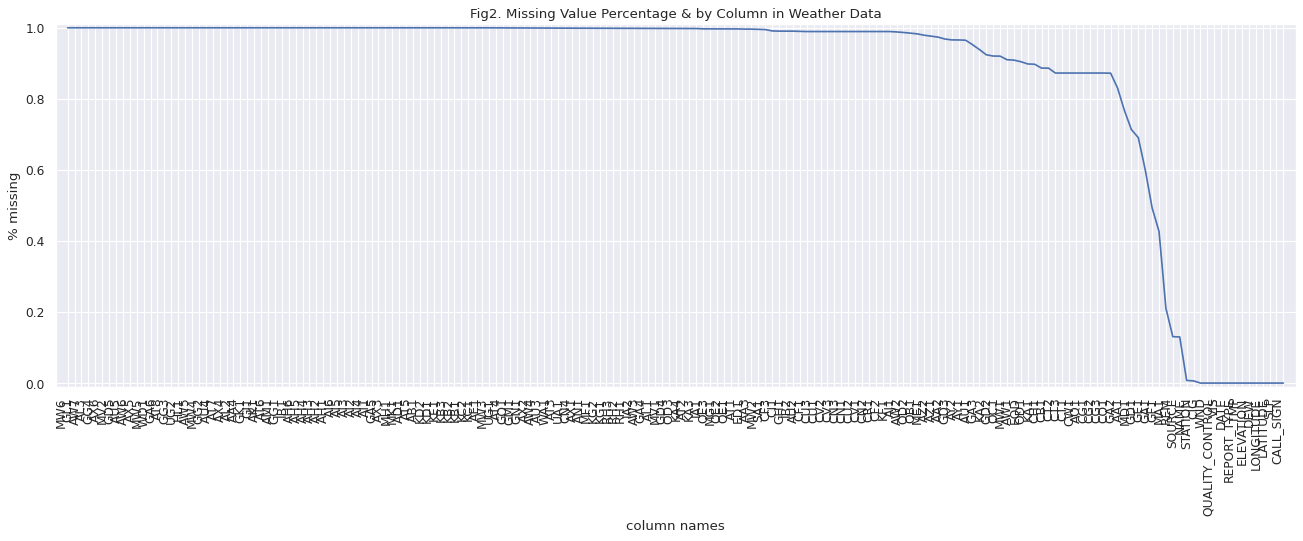

Text(0.5, 1.0, 'Fig2. Missing Value Percentage & by Column in Weather Data')

In [0]:
null_df = sum_null.toPandas()
null_plot_data = null_df.T.sort_values(null_df.index[-1], ascending=False)
null_plot_data.rename({0: '% missing'}, axis=1, inplace=True)
# sorting 
null_plot_data[0:30]
#
null_plot_data[0:30]

# null value graph 
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)
plt.plot(null_plot_data.index, null_plot_data['% missing'])
plt.xticks(null_plot_data.index, null_plot_data.index, rotation=90,
horizontalalignment='right')
plt.ylabel('% missing')
plt.xlabel('column names')
plt.margins(0.01)
plt.title('Fig2. Missing Value Percentage & by Column in Weather Data')
plt.show()

In [0]:
# Average null missing value 
null_plot_data['% missing'].mean()

Out[323]: 0.8716727664089474

In [0]:
# data load : This data contains the most updated variable list (including delay count)
df = spark.read.parquet(blob_url+'/masterData/df_master_data_full_arr_fn_delay_cnt.parquet').cache()

In [0]:
# add 'date' variables (2 hrs ahead of departure) 
df = df.withColumn("date",(df["CRS_DEP_TIME_UNIX"]-7200))

# Discussion of EDA  Challenge

This dataset posed several major strategic challenges for our team

**Challenges in flight data**: 

- Flight data was huge!
- Flight data had  31,746,841 duplicated values
- Flight data had 109 columns and we needed to filter related columns .
- Some columns are empty such as DIV1_TOTAL_GTIME ... 
- Flight data had null value in our target variable 
- Flight data was only origin and destination , and we had to use graph frame to find out the relation.
- Flight time was local time, and not UTC.
- None of us have subject matter expertise in aviation

**Challenges in weather data**:

- There are so many columns with unfamilar abbrviation.
- It took us long time to look up the document and match the name
- Some data has multiple values in one column such as MA1: 99999,9,10216,1
- There so many null and empty values
- We were not sure what to take out from the list since sometimes even if there are very rare, it could be serious 
   indicator for weather 
- None of us have subject matter expertise in weather

There were several instances where we were excited by a potential predictor like MV1, potential thunderstorms in the area, only to find that most of the values were missing. Conversely, we spent a great deal of time and effort parsing out the weather variables only to later discover that weather is not the leading cause of delays and that seasonality has a much greater impact.

**Challenges in station data**:

- It was hard to decide how many station's weather data we had to choose
- We used distnace from airport to station, and get single closest station's weather data from ahead of 2 - 6 time range

**General technical challenges**:

- There were also technical challenges with a large number of missing values and several attempts at imputation resulted in pipeline incompatibilities. Several attempts at one-hot encoding proved to perform impressively in both PCA and logistic regression with L1 regularization, but the coefficients were very difficult to map back to the original features, in other words, interpretability was compromised for performance. In the end, we decided to not use one-hot encoding for feature selection, but to use it for model performance tuning after feature selection by random forest feature importance.

# Exploratory Data Analysis

In this section, we started slicing the data to look for summary statistics like counts, means, etc. Then we started looking for relationships between the features and with the target variable.

In [0]:
eda=spark.read.parquet(blob_url+'/kris/df_final_0407_bruce.parquet')
# drop duplicated columns 
eda=eda.drop_duplicates()

#### Airports and flights
The graph below shows aiports and flights. The size of vertex represents the number of flights in an airport and the thickness of an edge is number of flights between two airports. Some small airports and those in islands are excluded.

Out[70]: Out[70]: Out[70]: Out[70]:

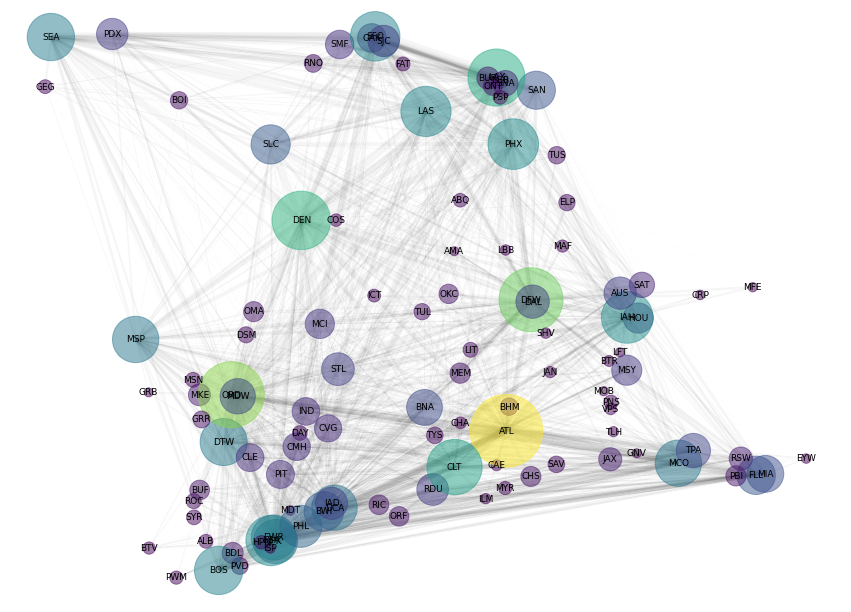

{'TUS': Text(0.32116, -110.941, 'TUS'),
 'RNO': Text(0.39498, -119.768, 'RNO'),
 'SMF': Text(0.38695, -121.591, 'SMF'),
 'MKE': Text(0.42947, -87.896, 'MKE'),
 'HOU': Text(0.29645, -95.279, 'HOU'),
 'JAN': Text(0.32311, -90.076, 'JAN'),
 'PWM': Text(0.43646, -70.309, 'PWM'),
 'ELP': Text(0.31806999999999996, -106.378, 'ELP'),
 'MSN': Text(0.4314, -89.337, 'MSN'),
 'MEM': Text(0.35042, -89.977, 'MEM'),
 'OMA': Text(0.41302, -95.894, 'OMA'),
 'DTW': Text(0.42212000000000005, -83.353, 'DTW'),
 'MDT': Text(0.40192999999999995, -76.763, 'MDT'),
 'GRB': Text(0.44484999999999997, -88.129, 'GRB'),
 'BTV': Text(0.44472, -73.153, 'BTV'),
 'ABQ': Text(0.3504, -106.609, 'ABQ'),
 'BHM': Text(0.33563000000000004, -86.753, 'BHM'),
 'BOI': Text(0.43564, -116.223, 'BOI'),
 'PVD': Text(0.41723999999999994, -71.428, 'PVD'),
 'MYR': Text(0.3368, -78.928, 'MYR'),
 'BDL': Text(0.41939, -72.683, 'BDL'),
 'DFW': Text(0.32896000000000003, -97.037, 'DFW'),
 'ICT': Text(0.3765, -97.433, 'ICT'),
 'LBB': Text(0.33664, -101.823, 'LBB'),
 'JFK': Text(0.4064, -73.779, 'JFK'),
 'BOS': Text(0.42363999999999996, -71.005, 'BOS'),
 'CRP': Text(0.2777, -97.501, 'CRP'),
 'LGB': Text(0.33818, -118.151, 'LGB'),
 'SAN': Text(0.32732999999999995, -117.189, 'SAN'),
 'AMA': Text(0.35219, -101.706, 'AMA'),
 'EWR': Text(0.40692, -74.169, 'EWR'),
 'LGA': Text(0.40777, -73.872, 'LGA'),
 'RDU': Text(0.35877000000000003, -78.787, 'RDU'),
 'DCA': Text(0.38852, -77.037, 'DCA'),
 'DAL': Text(0.32847000000000004, -96.852, 'DAL'),
 'LAX': Text(0.33942, -118.408, 'LAX'),
 'VPS': Text(0.30483, -86.525, 'VPS'),
 'JAX': Text(0.30494, -81.688, 'JAX'),
 'SNA': Text(0.33676, -117.868, 'SNA'),
 'ROC': Text(0.43119, -77.672, 'ROC'),
 'MCO': Text(0.28429, -81.316, 'MCO'),
 'ORD': Text(0.41979, -87.904, 'ORD'),
 'ORF': Text(0.36894, -76.201, 'ORF'),
 'GEG': Text(0.47619999999999996, -117.534, 'GEG'),
 'SEA': Text(0.47448999999999997, -122.309, 'SEA'),
 'DSM': Text(0.41534, -93.663, 'DSM'),
 'IAH': Text(0.2998, -95.34, 'IAH'),
 'FLL': Text(0.26072, -80.153, 'FLL'),
 'PHX': Text(0.33433999999999997, -112.008, 'PHX'),
 'SAT': Text(0.29534, -98.47, 'SAT'),
 'LAS': Text(0.3608, -115.152, 'LAS'),
 'TUL': Text(0.36198, -95.888, 'TUL'),
 'OAK': Text(0.37721, -122.221, 'OAK'),
 'IND': Text(0.39716999999999997, -86.294, 'IND'),
 'MSY': Text(0.29993, -90.258, 'MSY'),
 'OKC': Text(0.35393, -97.601, 'OKC'),
 'MSP': Text(0.44880000000000003, -93.217, 'MSP'),
 'CHS': Text(0.32899, -80.04, 'CHS'),
 'COS': Text(0.38805999999999996, -104.7, 'COS'),
 'PNS': Text(0.30473, -87.187, 'PNS'),
 'CAE': Text(0.33939, -81.119, 'CAE'),
 'MFE': Text(0.26176, -98.239, 'MFE'),
 'DAY': Text(0.39902, -84.219, 'DAY'),
 'CVG': Text(0.39046, -84.662, 'CVG'),
 'ILM': Text(0.34271, -77.903, 'ILM'),
 'BNA': Text(0.36124, -86.678, 'BNA'),
 'PBI': Text(0.26683, -80.096, 'PBI'),
 'TYS': Text(0.35812, -83.993, 'TYS'),
 'MOB': Text(0.30691, -88.243, 'MOB'),
 'CLE': Text(0.41412, -81.85, 'CLE'),
 'LFT': Text(0.30205, -91.987, 'LFT'),
 'DEN': Text(0.39858, -104.667, 'DEN'),
 'MAF': Text(0.31942, -102.202, 'MAF'),
 'ATL': Text(0.33640000000000003, -84.427, 'ATL'),
 'MDW': Text(0.41786, -87.752, 'MDW'),
 'BTR': Text(0.30533, -91.149, 'BTR'),
 'BWI': Text(0.39175, -76.668, 'BWI'),
 'SFO': Text(0.37619, -122.375, 'SFO'),
 'ALB': Text(0.42747999999999997, -73.803, 'ALB'),
 'RSW': Text(0.26536000000000004, -81.755, 'RSW'),
 'CHA': Text(0.35034999999999994, -85.204, 'CHA'),
 'PIT': Text(0.40491, -80.233, 'PIT'),
 'SHV': Text(0.32445999999999997, -93.826, 'SHV'),
 'BUR': Text(0.34201, -118.359, 'BUR'),
 'BUF': Text(0.4294, -78.732, 'BUF'),
 'LIT': Text(0.34729, -92.224, 'LIT'),
 'PHL': Text(0.39872, -75.241, 'PHL'),
 'MIA': Text(0.25793, -80.291, 'MIA'),
 'GNV': Text(0.2969, -82.272, 'GNV'),
 'PSP': Text(0.33829, -116.507, 'PSP'),
 'PDX': Text(0.45588999999999996, -122.597, 'PDX'),
 'EYW': Text(0.24556, -81.759, 'EYW'),
 'TLH': Text(0.30396, -84.35, 'TLH'),
 'TPA': Text(0.27975, -82.533, 'TPA'),
 'CLT': Text(0.35214, -80.943, 'CLT'),
 'AUS': Text

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

df_temp = eda.filter(eda['FL_YEAR'] == '2019').select('ORIGIN', "ORIGIN_LON", "ORIGIN_LAT", 'DEST', "DEST_LON", "DEST_LAT") \
              .filter( (eda['ORIGIN_LON'] > 1.0 ) & (eda['DEST_LON'] > 1.0 ))

# Count the number of records for each ORGIN
node_o_size = df_temp.groupBy('ORIGIN', "ORIGIN_LON", "ORIGIN_LAT").count()\
                .select(F.col('ORIGIN').alias('node'), F.col('ORIGIN_LON').alias("lon"), F.col('ORIGIN_LAT').alias("lat"), F.col("count").alias("n"))

# Count the number of records for each DEST
node_i_size = df_temp.groupBy('DEST', "DEST_LON", "DEST_LAT").count()\
                .select(F.col('DEST').alias('node'), F.col('DEST_LON').alias("lon"), F.col('DEST_LAT').alias("lat"), F.col("count").alias("n"))
node_size = node_i_size.union(node_o_size)
node_size = node_size.groupBy('node', "lon", "lat").sum("n")\
                    .select(F.col('node'), F.col('lon'), F.col('lat'), F.col('sum(n)').alias("n")).cache()

# Obtain (1) the list of airports, (2) their location, and (3) # flights
nodes = node_size.rdd.map(lambda x: x[0]).collect()
mx = node_size.rdd.map(lambda x: x[1]).collect()
my = node_size.rdd.map(lambda x: x[2]).collect()
weight = node_size.rdd.map(lambda x: x[3]).collect()

# Find the 
edge_weight = df_temp.groupBy('ORIGIN', 'DEST').count().rdd.map(lambda x: (x[0], x[1], x[2])).collect()

pos = {}
weight_final = []
nodes_final = []

# Excludes small airports and those in islands
exc_airports = ['GUM', 'PPG', 'FSM', 'SFB', 'HNL', 'SJU', 'ANC', 'KOA', 'OGG', 'LIH', 'ITO']
for idx, item in enumerate(nodes):
    if(item in exc_airports):
        continue
    
    if(weight[idx] < 10000): # number of flights in an airport 
        continue
    
    nodes_final.append(item)
    weight_final.append(weight[idx])
    pos[item] = (float(mx[idx])/100, float(my[idx]))
    
edge_list = [(item[0], item[1]) for item in edge_weight if (item[0] in nodes_final) and (item[1] in nodes_final)]
edge_w = [item[2]*0.001 for item in edge_weight if (item[0] in nodes_final) and (item[1] in nodes_final)]

# Draw a graph
G = nx.Graph() 
G.add_nodes_from(nodes_final)

plt.figure(3,figsize=(15,11)) 
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
nx.draw_networkx_nodes(G, nodelist = nodes_final, node_color = weight_final, pos = pos, node_size = [ w*0.008 for w in weight_final], alpha = 0.5)
nx.draw_networkx_edges(G, edgelist = edge_list, width = edge_w, pos = pos , alpha = 0.02)
nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(nodes_final,nodes_final)), font_size = 9, font_color = 'black')
plt.box(False)
plt.show()

## Delay Status and Pattern

Below we looked at the percentage of delay flights out of total flights in a day.

In [0]:
# Create Delay Only Table 

df3_dealay=eda.filter(eda.DEP_DEL15==1)
freq_table = df3_dealay.select(col("FL_DATE").cast("string")).groupBy("FL_DATE").count().toPandas()

# Calculating Percentage
freq_table['percent'] = (freq_table['count'] / 
                  freq_table['count'].sum()) * 100
freq_table.sort_values(by=['percent'],ascending=False)

delay=freq_table
delay

# Create Total Flight  table
freq_table = eda.select(col("FL_DATE").cast("string")).groupBy("FL_DATE").count().toPandas()

# Calculating Percentage
freq_table['percent'] = (freq_table['count'] / 
                  freq_table['count'].sum()) * 100
freq_table.sort_values(by=['percent'],ascending=False)

total=freq_table
total=total.fillna(0)

Out[327]: Out[327]:

FL_DATE 
 count 
 percent 
 
 
 
 
 0 
 2019-08-23 
 4319 
 0.079367 
 
 
 1 
 2019-08-08 
 5804 
 0.106655 
 
 
 2 
 2019-08-22 
 4583 
 0.084218 
 
 
 3 
 2015-05-01 
 1792 
 0.032930 
 
 
 4 
 2016-08-17 
 3128 
 0.057481 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 1820 
 2018-05-04 
 3459 
 0.063563 
 
 
 1821 
 2018-06-19 
 5092 
 0.093572 
 
 
 1822 
 2017-03-17 
 2455 
 0.045114 
 
 
 1823 
 2017-01-10 
 3486 
 0.064059 
 
 
 1824 
 2016-05-30 
 1598 
 0.029365 
 
 
 
 1825 rows × 3 columns

### Distribution of the count of delayed flights a day

We draw the histogram of the number of flights in U.S by daily. Usually 2000- 4000 flights delayed by daily. Higher case, we saw as many as 7000 flights delayed. Therefore, we could assume our delay prediction result per day better be within this average.

Out[330]: Out[330]:

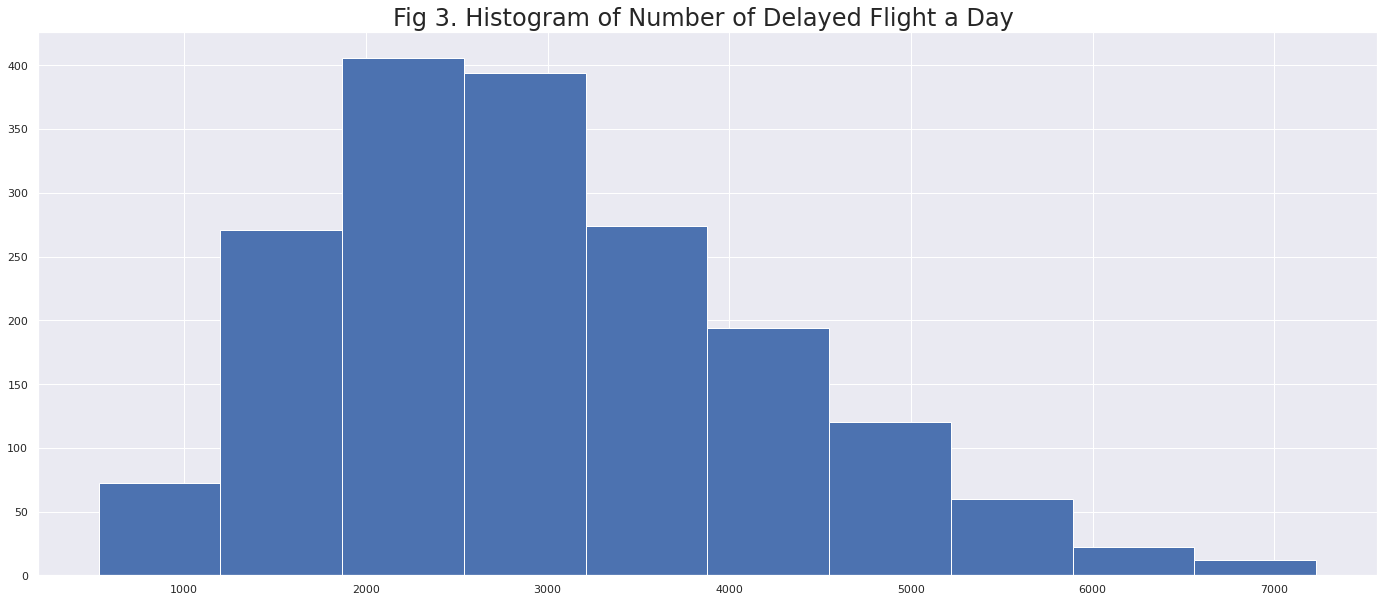

Text(0.5, 1.0, 'Fig 3. Histogram of Number of Delayed Flight a Day ')

In [0]:
delay['count'].hist()
plt.title('Fig 3. Histogram of Number of Delayed Flight a Day ',fontsize=24)

In [0]:
total=total.fillna(0)

In [0]:
# merge 
total=pd.merge(delay,total,on='FL_DATE',how='outer')

### Total Vs. Delay Pattern over Time

We have dataset from 2015 -2019, and we wanted to see the seasonal trend through this time frame. As we can see the gap from total and cancellation, there is no complete nation-wide shut down. As seen in Figure 4, the number of delayed flights peaked in December to January, and this may due to winter weather changes or holiday staffing difficulties. Therefore, we included month and quarter as our model variables.

Out[379]: Out[379]: Out[379]: Out[379]: Out[379]: Out[379]: Out[379]:

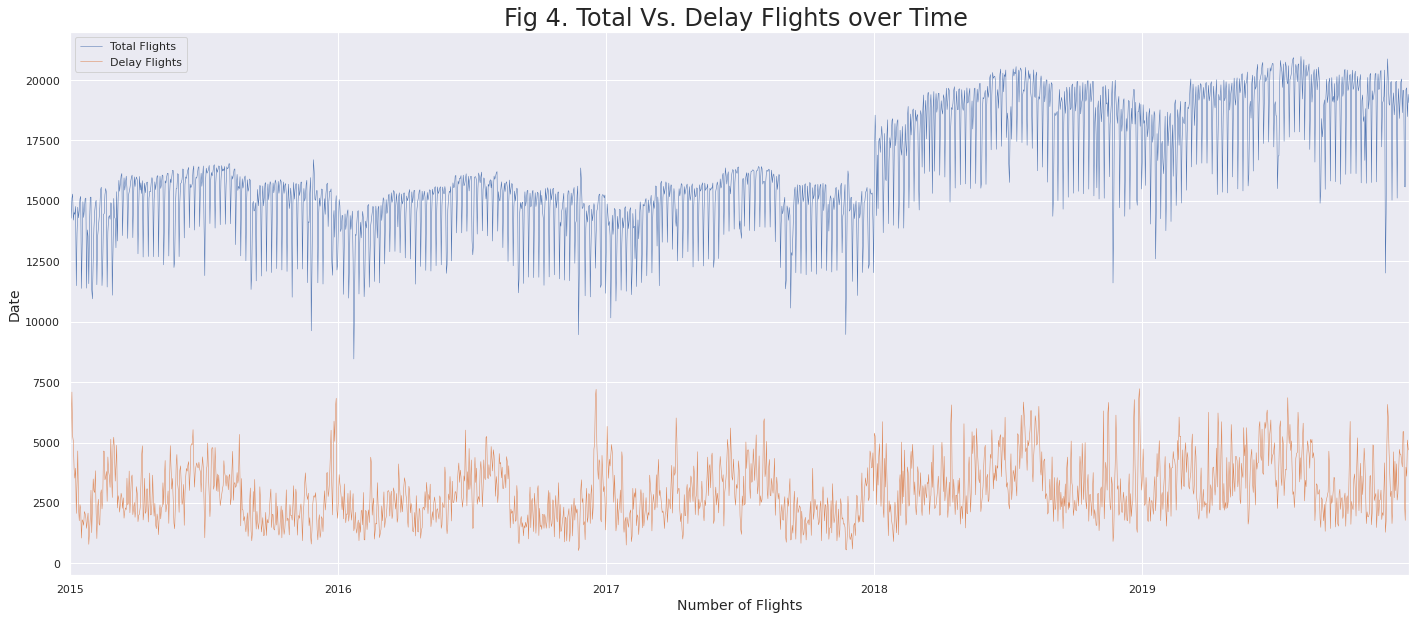

Text(0, 0.5, 'Date')

In [0]:
sns.set(rc={'figure.figsize':(24, 10)})

total3=total2
total3['FL_DATE']=pd.to_datetime(total3['FL_DATE'])
opsd_daily = total3.set_index('FL_DATE')
opsd_daily.head(3)
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.day_name()

# Display a random sampling of 5 rows
#opsd_daily.sample(5, random_state=0)

sns.set(rc={'figure.figsize':(24, 10)})
opsd_daily['total'].plot(linewidth=0.5)
opsd_daily['delay'].plot(linewidth=0.5)
plt.legend(labels=["Total Flights","Delay Flights"])
plt.title('Fig 4. Total Vs. Delay Flights over Time ',fontsize=24)
plt.xlabel('Number of Flights',fontsize=14)
plt.ylabel('Date',fontsize=14)

### Total Vs. Delay Pattern by Month

From above graph of Figure 4, we found that there seems to be seasonality trend in delay pattern. Therefore, we draw box plots to check the difference by month compared to total flights. We found out that June, July and December have the higher number of delay flights than the other months, which indicates the crowdness of summer and winter vacation seasons. Also compared to the total, more outliers are seen.

Out[334]: Out[334]: Out[334]: Out[334]: Out[334]: Out[334]: Out[334]:

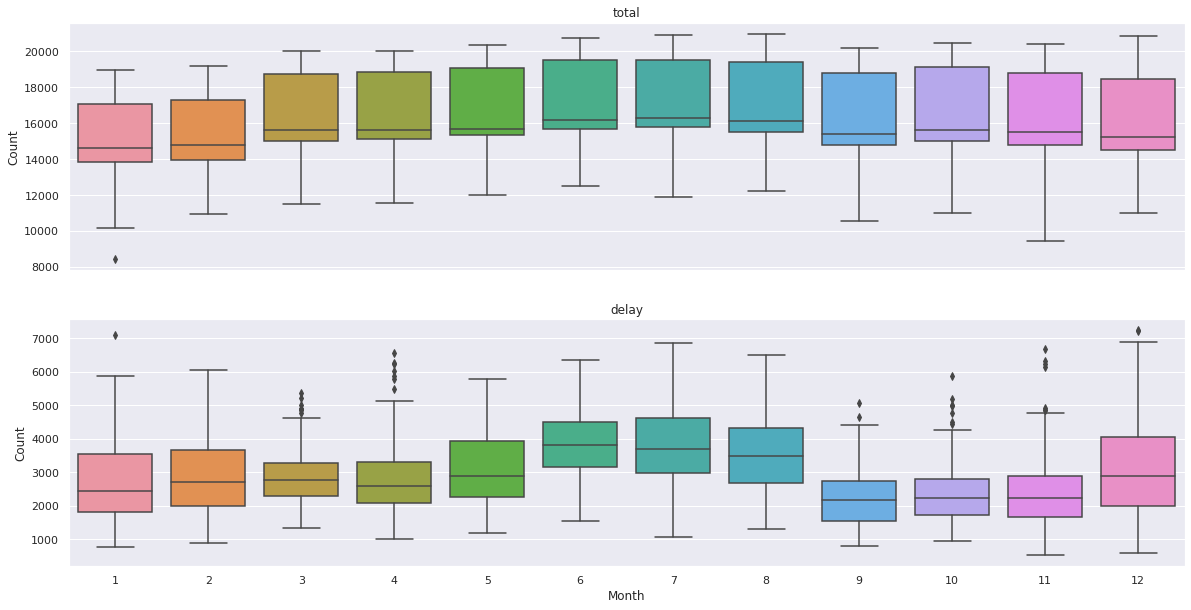

Text(0.5, 1.0, 'delay')

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
for name, ax in zip(['total', 'delay'], axes):
  sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
  ax.set_ylabel('Count')
  ax.set_title(name)
  # Remove the automatic x-axis label from all but the bottom subplot
  if ax != axes[-1]:
      ax.set_xlabel('')

### Total Vs. Delay Pattern by Weekday

Comparing days in a week between total and delay, we found out there are not much difference except weekends showed more outliers in delayed flights.

Out[335]: Out[335]: Out[335]: Out[335]: Out[335]: Out[335]: Out[335]:

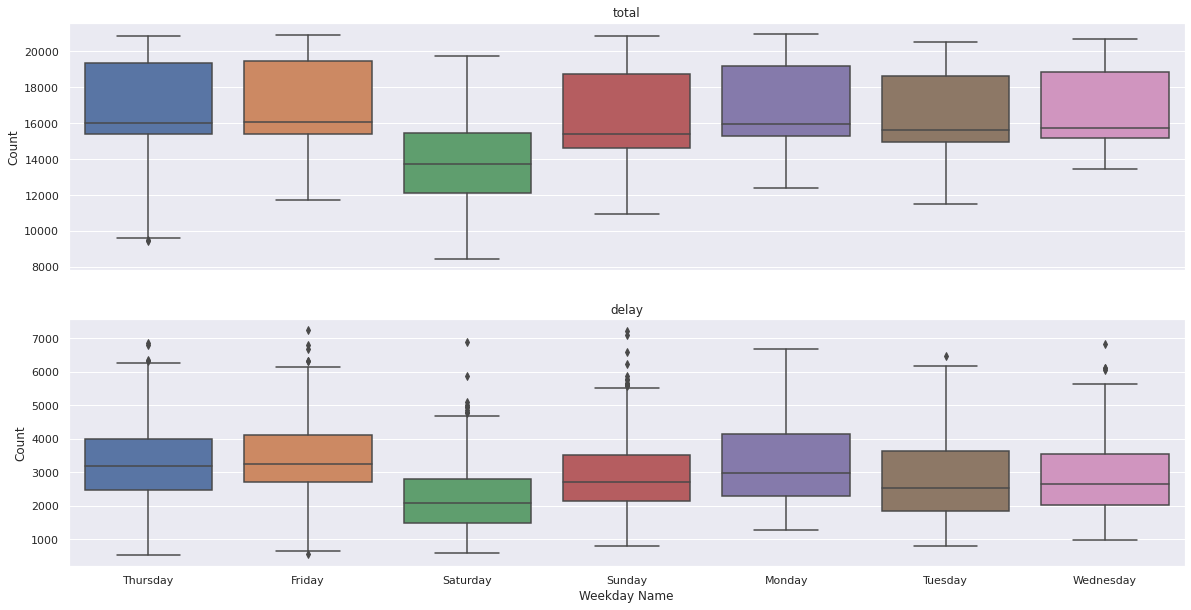

Text(0.5, 1.0, 'delay')

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
for name, ax in zip(['total', 'delay'], axes):
  sns.boxplot(data=opsd_daily, x='Weekday Name', y=name, ax=ax)
  ax.set_ylabel('Count')
  ax.set_title(name)
  # Remove the automatic x-axis label from all but the bottom subplot
  if ax != axes[-1]:
      ax.set_xlabel('')

In [0]:
# Type check 
data_types = defaultdict(list)
for entry in eda.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)
    
catCols = [x for (x, dataType) in eda.dtypes if dataType == "string" ]
numCols = [x for (x, dataType) in eda.dtypes if (((dataType == "double") | (dataType == "int")))]  # label col name
print('Catergory columns are: ')
print(catCols)
print(len(catCols))
print('Numerical columns are: ')
print(numCols)
print(len(numCols))

Catergory columns are: 
['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 'vis_dist', 'ka1_code', 'vis_dist_arr', 'ka1_code_arr']
11
Numerical columns are: 
['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'CANCELLED', 'DISTANCE', 'ORIGIN_LON', 'ORIGIN_LAT', 'DEST_LON', 'DEST_LAT', 'CRS_DEP_TIME_UNIX', 'CRS_ARR_TIME_UNIX', 'dew_temp', 'wnd_speed', 'ka2_temp', 'tmp_air_temp', 'ma1_pre_rate', 'ma1_pre_qual', 'wnd_dir_angle', 'slp_sea_pre', 'cig_qual', 'md1_3_hr_qual', 'ka1_temp', 'cig_height', 'ka2_period_qual', 'count', 'count_normal', 'diff_hrs_delay', 'dew_temp_arr', 'wnd_speed_arr', 'ka2_temp_arr', 'tmp_air_temp_arr', 'ma1_pre_rate_arr', 'ma1_pre_qual_arr', 'wnd_dir_angle_arr', 'slp_sea_pre_arr', 'cig_qual_arr', 'md1_3_hr_qual_arr', 'ka1_temp_arr', 'cig_height_arr', 'ka2_period_qual_arr', 'diff_hrs_arr', 'FL_YEAR', 'PR_SCORE', 'QUARTER_imputed', 'MONTH_imputed', 'DAY_OF_MONTH_imputed', 'DAY_OF_WEEK_imputed', 'DEP_DEL15_imputed', 'CANCELLED_imputed', 'DISTANCE_imputed', 'ORIGIN_LON_imputed', 'ORIGIN_LAT_imputed', 'DEST_LON_imputed', 'DEST_LAT_imputed', 'CRS_DEP_TIME_UNIX_imputed', 'CRS_ARR_TIME_UNIX_imputed', 'dew_temp_imputed', 'wnd_speed_imputed', 'ka2_temp_imputed', 'tmp_air_temp_imputed', 'ma1_pre_rate_imputed', 'ma1_pre_qual_imputed', 'wnd_dir_angle_imputed', 'slp_sea_pre_imputed', 'cig_qual_imputed', 'md1_3_hr_qual_imputed', 'ka1_temp_imputed', 'cig_height_imputed', 'ka2_period_qual_imputed', 'count_imputed', 'count_normal_imputed', 'diff_hrs_delay_imputed', 'dew_temp_arr_imputed', 'wnd_speed_arr_imputed', 'ka2_temp_arr_imputed', 'tmp_air_temp_arr_imputed', 'ma1_pre_rate_arr_imputed', 'ma1_pre_qual_arr_imputed', 'wnd_dir_angle_arr_imputed', 'slp_sea_pre_arr_imputed', 'cig_qual_arr_imputed', 'md1_3_hr_qual_arr_imputed', 'ka1_temp_arr_imputed', 'cig_height_arr_imputed', 'ka2_period_qual_arr_imputed', 'diff_hrs_arr_imputed', 'FL_YEAR_imputed', 'PR_SCORE_imputed', 'FL_DATE_string_encoded', 'OP_UNIQUE_CARRIER_string_encoded', 'TAIL_NUM_string_encoded', 'ORIGIN_string_encoded', 'ORIGIN_STATE_ABR_string_encoded', 'DEST_string_encoded', 'DEST_STATE_ABR_string_encoded', 'vis_dist_string_encoded', 'ka1_code_string_encoded', 'vis_dist_arr_string_encoded', 'ka1_code_arr_string_encoded']
101

In [0]:
eda_hist=eda.select([a for a in numCols])

b_list=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DEL15',
       'DISTANCE', 'ORIGIN_LON', 'ORIGIN_LAT', 'DEST_LON',
       'DEST_LAT', 'CRS_DEP_TIME_UNIX', 'CRS_ARR_TIME_UNIX', 'dew_temp',
       'wnd_speed', 'ka2_temp', 'tmp_air_temp', 'ma1_pre_rate', 'ma1_pre_qual',
       'wnd_dir_angle', 'slp_sea_pre', 'cig_qual', 'md1_3_hr_qual', 'ka1_temp',
       'cig_height', 'ka2_period_qual', 'count', 'count_normal',
       'dew_temp_arr', 'wnd_speed_arr', 'ka2_temp_arr',
       'tmp_air_temp_arr', 'ma1_pre_rate_arr', 'ma1_pre_qual_arr',
       'wnd_dir_angle_arr', 'slp_sea_pre_arr', 'cig_qual_arr',
       'md1_3_hr_qual_arr', 'ka1_temp_arr', 'cig_height_arr',
       'ka2_period_qual_arr', 'diff_hrs_arr', 'FL_YEAR', 'PR_SCORE']

eda_hist=eda_hist.select([a for a in b_list])

### Cancellation and Delay patern by Airline  Carrier Status

In this section, we want to look at the cancellation and delay rates of the airlines. We also want to understand the contribution of weather to delays. 
In terms of cancellation, it turns out that (American Eagle Airlines) showed the highest rate of cancellation compared to its total flight recorded followed by PSA Airlines. 
In terms of delay, B6 (JetBlue AIrways Corporation) followed by F9 (FRONTIER FLIGHT). We wanted to examine delay rate again without weather delay reason, and found out that NK (Spirit Airlines) ranked 3rd highest.

In [0]:
df_airlines2=df_airlines.drop_duplicates()
df_cancel = df_airlines2.filter(df_airlines2.CANCELLED==1)\
                    .select('OP_CARRIER', 'DEP_DEL15')\
                    .groupby('OP_CARRIER')\
                    .count()\
                    .withColumnRenamed('count', 'numCancalled')

df_total = df_airlines2.groupby('OP_CARRIER')\
                   .count()\
                   .withColumnRenamed('count', 'numTotalFlights')

df_total = df_total.join(df_cancel, on='OP_CARRIER')
df = df_total.withColumn('pctCancalled', F.round(df_total['numCancalled'] / df_total['numTotalFlights'] *100, 2))\
        .sort(F.col('pctCancalled').desc())
df.show()

+----------+---------------+------------+------------+
OP_CARRIER|numTotalFlights|numCancalled|pctCancalled|
+----------+---------------+------------+------------+
 MQ| 917640| 37110| 4.04|
 OH| 567761| 18696| 3.29|
 EV| 1740081| 48842| 2.81|
 YV| 443026| 12239| 2.76|
 YX| 645239| 17792| 2.76|
 9E| 503049| 10612| 2.11|
 US| 198715| 4067| 2.05|
 NK| 793419| 15101| 1.9|
 B6| 1450596| 26544| 1.83|
 OO| 3511395| 56927| 1.62|
 AA| 4400421| 69020| 1.57|
 WN| 6607241| 101852| 1.54|
 F9| 544562| 7342| 1.35|
 VX| 219675| 2669| 1.21|
 UA| 2892746| 28289| 0.98|
 AS| 1045446| 8276| 0.79|
 G4| 201526| 1393| 0.69|
 DL| 4663456| 22270| 0.48|
 HA| 400847| 906| 0.23|
+----------+---------------+------------+------------+

In [0]:
df_delay = df_airlines2.filter(df_airlines2.DEP_DEL15==1)\
                    .select('OP_CARRIER', 'DEP_DEL15')\
                    .groupby('OP_CARRIER')\
                    .count()\
                    .withColumnRenamed('count', 'numDelayed')

df_total = df_airlines2.groupby('OP_CARRIER')\
                   .count()\
                   .withColumnRenamed('count', 'numTotalFlights')

df_total = df_total.join(df_delay, on='OP_CARRIER')
df_del = df_total.withColumn('pctDelayed', F.round(df_total['numDelayed'] / df_total['numTotalFlights'] *100, 2))\
        .sort(F.col('pctDelayed').desc())
df_del.show()

+----------+---------------+----------+----------+
OP_CARRIER|numTotalFlights|numDelayed|pctDelayed|
+----------+---------------+----------+----------+
 B6| 1450596| 357526| 24.65|
 F9| 544562| 131329| 24.12|
 VX| 219675| 46242| 21.05|
 WN| 6607241| 1372940| 20.78|
 G4| 201526| 40518| 20.11|
 NK| 793419| 158470| 19.97|
 OH| 567761| 108396| 19.09|
 UA| 2892746| 547093| 18.91|
 YV| 443026| 79801| 18.01|
 MQ| 917640| 162587| 17.72|
 EV| 1740081| 306472| 17.61|
 AA| 4400421| 772281| 17.55|
 9E| 503049| 84295| 16.76|
 OO| 3511395| 568364| 16.19|
 YX| 645239| 101325| 15.7|
 US| 198715| 29144| 14.67|
 DL| 4663456| 662764| 14.21|
 AS| 1045446| 133502| 12.77|
 HA| 400847| 30492| 7.61|
+----------+---------------+----------+----------+

In [0]:
# without weather delay 
df_delay = df_airlines2.filter((df_airlines2.DEP_DEL15==1) & (df_airlines2.WEATHER_DELAY==0))\
                    .select('OP_CARRIER', 'DEP_DEL15')\
                    .groupby('OP_CARRIER')\
                    .count()\
                    .withColumnRenamed('count', 'numDelayed')

df_total = df_airlines2.groupby('OP_CARRIER')\
                   .count()\
                   .withColumnRenamed('count', 'numTotalFlights')

df_total = df_total.join(df_delay, on='OP_CARRIER')
df_del = df_total.withColumn('pctDelayed', F.round(df_total['numDelayed'] / df_total['numTotalFlights'] *100, 2))\
        .sort(F.col('pctDelayed').desc())
df_del.show()

+----------+---------------+----------+----------+
OP_CARRIER|numTotalFlights|numDelayed|pctDelayed|
+----------+---------------+----------+----------+
 B6| 1450596| 282026| 19.44|
 F9| 544562| 103830| 19.07|
 NK| 793419| 126870| 15.99|
 VX| 219675| 35074| 15.97|
 G4| 201526| 31373| 15.57|
 WN| 6607241| 995717| 15.07|
 EV| 1740081| 255650| 14.69|
 YV| 443026| 63830| 14.41|
 OH| 567761| 79868| 14.07|
 UA| 2892746| 388970| 13.45|
 9E| 503049| 64951| 12.91|
 AA| 4400421| 566803| 12.88|
 OO| 3511395| 450173| 12.82|
 MQ| 917640| 116733| 12.72|
 YX| 645239| 79492| 12.32|
 US| 198715| 22114| 11.13|
 AS| 1045446| 101336| 9.69|
 DL| 4663456| 429381| 9.21|
 HA| 400847| 24373| 6.08|
+----------+---------------+----------+----------+

## Summary Visualization & Statistics of Features

A summary of all of the variables helped to reveal features with high variability and range. Also in order to efficiently plot histograms and box plots, we randomly sampled 1% of the total data set and tranformed the sample into a Pandas dataframe.

In [0]:
# statistics 
eda_hist.describe().toPandas()

Out[378]:

summary 
 QUARTER 
 MONTH 
 DAY_OF_MONTH 
 DAY_OF_WEEK 
 DEP_DEL15 
 DISTANCE 
 ORIGIN_LON 
 ORIGIN_LAT 
 DEST_LON 
 DEST_LAT 
 CRS_DEP_TIME_UNIX 
 CRS_ARR_TIME_UNIX 
 dew_temp 
 wnd_speed 
 ka2_temp 
 tmp_air_temp 
 ma1_pre_rate 
 ma1_pre_qual 
 wnd_dir_angle 
 slp_sea_pre 
 cig_qual 
 md1_3_hr_qual 
 ka1_temp 
 cig_height 
 ka2_period_qual 
 count 
 count_normal 
 dew_temp_arr 
 wnd_speed_arr 
 ka2_temp_arr 
 tmp_air_temp_arr 
 ma1_pre_rate_arr 
 ma1_pre_qual_arr 
 wnd_dir_angle_arr 
 slp_sea_pre_arr 
 cig_qual_arr 
 md1_3_hr_qual_arr 
 ka1_temp_arr 
 cig_height_arr 
 ka2_period_qual_arr 
 diff_hrs_arr 
 FL_YEAR 
 PR_SCORE 
 
 
 
 
 0 
 count 
 29690834 
 29690834 
 29690834 
 29690834 
 29686517 
 29690834 
 29690834 
 29690834 
 28158103 
 28158103 
 29690834 
 29690834 
 29597774 
 29596665 
 4393331 
 29603226 
 29274451 
 29600590 
 25540735 
 27648104 
 29690834 
 9351870 
 4456453 
 25648048 
 4393331 
 29690834 
 29690834 
 27704459 
 27704772 
 4168268 
 27715766 
 27392286 
 27706995 
 23890107 
 25882631 
 27885221 
 8770458 
 4241639 
 24070213 
 4168268 
 27885221 
 29690834 
 29253333 
 
 
 1 
 mean 
 2.522181054260719 
 6.5654837449160235 
 15.746903034114839 
 3.936781263874231 
 0.1833097159899223 
 842.563289566066 
 36.54108375623631 
 -94.98994956963396 
 36.362375568396864 
 -94.96376056858855 
 1.5035487743322766E9 
 1.5035545027175481E9 
 87.12240055620398 
 38.87444750954204 
 127.32408826013793 
 170.26498199892134 
 9880.789235808385 
 4.390877715613101 
 192.22031910984552 
 10165.848015726504 
 5.386592710733555 
 5.069152265803524 
 205.9782937237305 
 12466.307330483785 
 141.41908269602268 
 6.4960439979557325 
 0.055315327535280075 
 87.92546997578982 
 38.7293065252441 
 126.09717465383704 
 171.04852703692188 
 9888.825978671513 
 4.405426427514063 
 192.41785367474495 
 10165.941885351609 
 5.392328574336922 
 5.160152183614584 
 204.91543103974666 
 12511.951103423971 
 144.42615973828939 
 2.427329392512109 
 2017.140800793942 
 0.016245890932237158 
 
 
 2 
 stddev 
 1.104896717726657 
 3.396385660373114 
 8.77124795143709 
 1.9912354055858106 
 0.38692023603910203 
 614.3010828282902 
 6.2483912771349575 
 19.295865551397387 
 6.486780669107934 
 19.88080888184682 
 4.600652607329052E7 
 4.600638472935149E7 
 102.67138512393174 
 24.47376717506266 
 97.45513808304608 
 103.59518650156069 
 438.07544717842006 
 1.5551209099267254 
 99.45554462050883 
 66.50593899708986 
 1.6333528184209747 
 3.9994054225437914 
 102.9805616266936 
 9664.653584365338 
 67.64744473446041 
 10.1432254196415 
 0.09239872666107261 
 102.55714264927154 
 24.39671780654378 
 99.65674127024874 
 102.84091531788161 
 431.24452284344585 
 1.5455271283046257 
 99.51117906316165 
 66.40510856168993 
 1.6313388921746603 
 3.9967959326941442 
 103.10633894614891 
 9667.665013739666 
 69.13753723385972 
 0.2921624368043067 
 1.428950786086961 
 0.01239959353773015 
 
 
 3 
 min 
 1.0 
 1.0 
 1.0 
 1.0 
 0.0 
 25.0 
 0.0 
 -176.646 
 -14.331 
 -176.646 
 1.4200953E9 
 1.42008852E9 
 -440.0 
 0.0 
 -444.0 
 -439.0 
 7750.0 
 0.0 
 4.0 
 9645.0 
 1.0 
 0.0 
 -589.0 
 0.0 
 60.0 
 0.0 
 0.0 
 -450.0 
 0.0 
 -456.0 
 -456.0 
 6894.0 
 0.0 
 4.0 
 9602.0 
 1.0 
 0.0 
 -417.0 
 0.0 
 60.0 
 2.0 
 2015.0 
 8.6335645324808E-4 
 
 
 4 
 max 
 4.0 
 12.0 
 31.0 
 7.0 
 1.0 
 5095.0 
 71.285 
 0.0 
 71.285 
 144.797 
 1.5777684E9 
 1.57778634E9 
 340.0 
 530.0 
 9999.0 
 500.0 
 10483.0 
 9.0 
 360.0 
 10569.0 
 9.0 
 9.0 
 539.0 
 22000.0 
 240.0 
 226.0 
 1.0 
 340.0 
 618.0 
 9999.0 
 520.0 
 10509.0 
 9.0 
 360.0 
 10556.0 
 9.0 
 9.0 
 530.0 
 22000.0 
 240.0 
 5.0 
 2019.0 
 0.05510525088164758

In [0]:
eda_hist_sam

Out[383]:

QUARTER 
 MONTH 
 DAY_OF_MONTH 
 DAY_OF_WEEK 
 DEP_DEL15 
 DISTANCE 
 ORIGIN_LON 
 ORIGIN_LAT 
 DEST_LON 
 DEST_LAT 
 CRS_DEP_TIME_UNIX 
 CRS_ARR_TIME_UNIX 
 dew_temp 
 wnd_speed 
 ka2_temp 
 tmp_air_temp 
 ma1_pre_rate 
 ma1_pre_qual 
 wnd_dir_angle 
 slp_sea_pre 
 cig_qual 
 md1_3_hr_qual 
 ka1_temp 
 cig_height 
 ka2_period_qual 
 count 
 count_normal 
 dew_temp_arr 
 wnd_speed_arr 
 ka2_temp_arr 
 tmp_air_temp_arr 
 ma1_pre_rate_arr 
 ma1_pre_qual_arr 
 wnd_dir_angle_arr 
 slp_sea_pre_arr 
 cig_qual_arr 
 md1_3_hr_qual_arr 
 ka1_temp_arr 
 cig_height_arr 
 ka2_period_qual_arr 
 diff_hrs_arr 
 FL_YEAR 
 PR_SCORE 
 
 
 
 
 0 
 3.0 
 9.0 
 21.0 
 6.0 
 0.0 
 73.0 
 39.858 
 -104.667 
 38.806 
 -104.700 
 1.569108e+09 
 1.569111e+09 
 -22.0 
 103.0 
 NaN 
 250.0 
 8311.0 
 1.0 
 110.0 
 10063.0 
 1.0 
 1.0 
 NaN 
 22000.0 
 NaN 
 12.0 
 0.044643 
 -56.0 
 82.0 
 NaN 
 244.0 
 8086.0 
 5.0 
 150.0 
 10067.0 
 5.0 
 9.0 
 NaN 
 22000.0 
 NaN 
 2.350000 
 2019.0 
 0.025282 
 
 
 1 
 2.0 
 5.0 
 4.0 
 6.0 
 0.0 
 1024.0 
 47.449 
 -122.309 
 39.858 
 -104.667 
 1.557022e+09 
 1.557035e+09 
 67.0 
 57.0 
 83.0 
 206.0 
 9979.0 
 1.0 
 10.0 
 10146.0 
 9.0 
 1.0 
 206.0 
 NaN 
 120.0 
 2.0 
 0.000000 
 -44.0 
 82.0 
 50.0 
 211.0 
 8291.0 
 1.0 
 320.0 
 10057.0 
 9.0 
 1.0 
 222.0 
 NaN 
 120.0 
 2.050000 
 2019.0 
 0.018162 
 
 
 2 
 4.0 
 10.0 
 17.0 
 4.0 
 0.0 
 273.0 
 40.640 
 -73.779 
 43.646 
 -70.309 
 1.571344e+09 
 1.571349e+09 
 50.0 
 129.0 
 117.0 
 144.0 
 9928.0 
 1.0 
 270.0 
 9938.0 
 9.0 
 1.0 
 144.0 
 NaN 
 120.0 
 12.0 
 0.131579 
 44.0 
 57.0 
 106.0 
 106.0 
 9772.0 
 1.0 
 200.0 
 9791.0 
 9.0 
 1.0 
 139.0 
 NaN 
 120.0 
 2.500000 
 2019.0 
 0.012078 
 
 
 3 
 2.0 
 6.0 
 7.0 
 5.0 
 1.0 
 300.0 
 29.690 
 -82.272 
 33.640 
 -84.427 
 1.559942e+09 
 1.559948e+09 
 228.0 
 26.0 
 NaN 
 272.0 
 10065.0 
 5.0 
 290.0 
 10121.0 
 5.0 
 NaN 
 NaN 
 22000.0 
 NaN 
 0.0 
 0.000000 
 211.0 
 36.0 
 NaN 
 306.0 
 9702.0 
 5.0 
 230.0 
 10058.0 
 5.0 
 NaN 
 NaN 
 7620.0 
 NaN 
 2.450000 
 2019.0 
 0.001303 
 
 
 4 
 3.0 
 7.0 
 25.0 
 3.0 
 0.0 
 854.0 
 29.980 
 -95.340 
 28.429 
 -81.316 
 1.532553e+09 
 1.532565e+09 
 194.0 
 46.0 
 NaN 
 350.0 
 10124.0 
 5.0 
 60.0 
 10162.0 
 5.0 
 NaN 
 NaN 
 22000.0 
 NaN 
 8.0 
 0.049180 
 239.0 
 46.0 
 NaN 
 306.0 
 10100.0 
 5.0 
 210.0 
 10136.0 
 5.0 
 NaN 
 NaN 
 7620.0 
 NaN 
 2.200000 
 2018.0 
 0.020896 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 29722 
 1.0 
 3.0 
 23.0 
 4.0 
 0.0 
 337.0 
 39.872 
 -75.241 
 35.877 
 -78.787 
 1.490281e+09 
 1.490287e+09 
 -144.0 
 67.0 
 NaN 
 -22.0 
 10365.0 
 5.0 
 350.0 
 10375.0 
 5.0 
 NaN 
 NaN 
 22000.0 
 NaN 
 6.0 
 0.060606 
 -111.0 
 62.0 
 NaN 
 39.0 
 10194.0 
 5.0 
 50.0 
 10358.0 
 5.0 
 NaN 
 NaN 
 22000.0 
 NaN 
 2.150000 
 2017.0 
 0.009055 
 
 
 29723 
 4.0 
 11.0 
 3.0 
 5.0 
 0.0 
 239.0 
 32.847 
 -96.852 
 29.645 
 -95.279 
 1.509754e+09 
 1.509758e+09 
 122.0 
 26.0 
 NaN 
 217.0 
 9991.0 
 5.0 
 290.0 
 10165.0 
 5.0 
 NaN 
 NaN 
 22000.0 
 NaN 
 4.0 
 0.052632 
 239.0 
 41.0 
 NaN 
 289.0 
 10149.0 
 5.0 
 150.0 
 10168.0 
 5.0 
 NaN 
 NaN 
 22000.0 
 NaN 
 2.116667 
 2017.0 
 0.010511 
 
 
 29724 
 3.0 
 9.0 
 24.0 
 7.0 
 0.0 
 331.0 
 35.214 
 -80.943 
 38.852 
 -77.037 
 1.506290e+09 
 1.506295e+09 
 189.0 
 21.0 
 NaN 
 294.0 
 9894.0 
 5.0 
 NaN 
 10163.0 
 5.0 
 NaN 
 NaN 
 7620.0 
 NaN 
 4.0 
 0.014286 
 183.0 
 36.0 
 NaN 
 328.0 
 10149.0 
 5.0 
 90.0 
 10172.0 
 5.0 
 NaN 
 NaN 
 7620.0 
 NaN 
 2.033333 
 2017.0 
 0.014859 
 
 
 29725 
 2.0 
 5.0 
 1.0 
 5.0 
 0.0 
 641.0 
 39.858 
 -104.667 
 32.896 
 -97.037 
 1.430510e+09 
 1.430520e+09 
 89.0 
 36.0 
 NaN 
 144.0 
 8367.0 
 5.0 
 130.0 
 10168.0 
 5.0 
 NaN 
 NaN 
 732.0 
 NaN 
 4.0 
 0.008929 
 133.0 
 21.0 
 N

#### Feature Histograms

From the histograms, weather features appear to follow a skewed normal distribution. Date features seem to be uniformly distributed. Surprisingly, origin and destination longitude and latitude also exhibit skewed normal distribution. If we had more subject matter expertise, we would consider different approaches to interpret and handle the sensor quality attributes.

Out[384]:

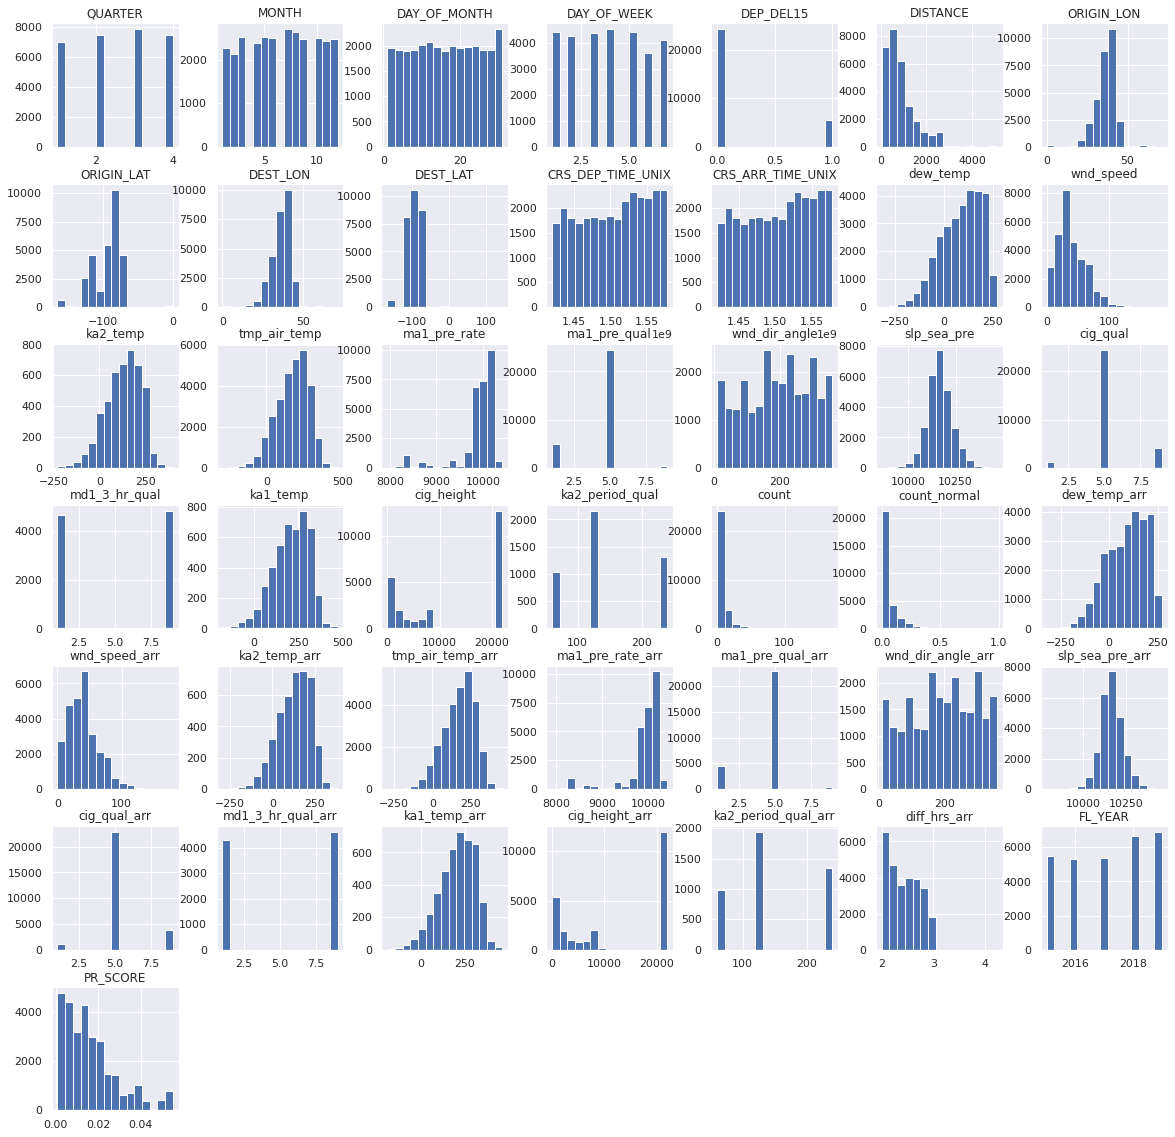

array([[<AxesSubplot:title={'center':'QUARTER'}>,
 <AxesSubplot:title={'center':'MONTH'}>,
 <AxesSubplot:title={'center':'DAY_OF_MONTH'}>,
 <AxesSubplot:title={'center':'DAY_OF_WEEK'}>,
 <AxesSubplot:title={'center':'DEP_DEL15'}>,
 <AxesSubplot:title={'center':'DISTANCE'}>,
 <AxesSubplot:title={'center':'ORIGIN_LON'}>],
 [<AxesSubplot:title={'center':'ORIGIN_LAT'}>,
 <AxesSubplot:title={'center':'DEST_LON'}>,
 <AxesSubplot:title={'center':'DEST_LAT'}>,
 <AxesSubplot:title={'center':'CRS_DEP_TIME_UNIX'}>,
 <AxesSubplot:title={'center':'CRS_ARR_TIME_UNIX'}>,
 <AxesSubplot:title={'center':'dew_temp'}>,
 <AxesSubplot:title={'center':'wnd_speed'}>],
 [<AxesSubplot:title={'center':'ka2_temp'}>,
 <AxesSubplot:title={'center':'tmp_air_temp'}>,
 <AxesSubplot:title={'center':'ma1_pre_rate'}>,
 <AxesSubplot:title={'center':'ma1_pre_qual'}>,
 <AxesSubplot:title={'center':'wnd_dir_angle'}>,
 <AxesSubplot:title={'center':'slp_sea_pre'}>,
 <AxesSubplot:title={'center':'cig_qual'}>],
 [<AxesSubplot:title={'center':'md1_3_hr_qual'}>,
 <AxesSubplot:title={'center':'ka1_temp'}>,
 <AxesSubplot:title={'center':'cig_height'}>,
 <AxesSubplot:title={'center':'ka2_period_qual'}>,
 <AxesSubplot:title={'center':'count'}>,
 <AxesSubplot:title={'center':'count_normal'}>,
 <AxesSubplot:title={'center':'dew_temp_arr'}>],
 [<AxesSubplot:title={'center':'wnd_speed_arr'}>,
 <AxesSubplot:title={'center':'ka2_temp_arr'}>,
 <AxesSubplot:title={'center':'tmp_air_temp_arr'}>,
 <AxesSubplot:title={'center':'ma1_pre_rate_arr'}>,
 <AxesSubplot:title={'center':'ma1_pre_qual_arr'}>,
 <AxesSubplot:title={'center':'wnd_dir_angle_arr'}>,
 <AxesSubplot:title={'center':'slp_sea_pre_arr'}>],
 [<AxesSubplot:title={'center':'cig_qual_arr'}>,
 <AxesSubplot:title={'center':'md1_3_hr_qual_arr'}>,
 <AxesSubplot:title={'center':'ka1_temp_arr'}>,
 <AxesSubplot:title={'center':'cig_height_arr'}>,
 <AxesSubplot:title={'center':'ka2_period_qual_arr'}>,
 <AxesSubplot:title={'center':'diff_hrs_arr'}>,
 <AxesSubplot:title={'center':'FL_YEAR'}>],
 [<AxesSubplot:title={'center':'PR_SCORE'}>, <AxesSubplot:>,
 <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
 <AxesSubplot:>]], dtype=object)

In [0]:
# Plot histograms of all of the features
eda_hist_sam.hist(figsize=(20,20), bins=15)

#### Boxplots between delay vs. non-delayed

To understand the differences between delayed and not-delayed flightes across all of the features, we'll look at the differences in boxplot distributions. 
Surprisingly, there are noticable differences in the distributions of delay versus not-delayed with respect to quarter. In general, flights are more likely to be delayed in the first half of the year. Wind speed does seem to be higher for cancelled flights, which aligns with having that variable in the model and  cig (Ceiling height) appeared to be higher from delayed.  Also, the feature of count (delay status of origion airport) appears to be higher than non-delay. We can assume that the previous status of airport affects the next departure of flight

In [0]:
FIELDS = eda_hist_sam.columns.tolist()

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[387]: /databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

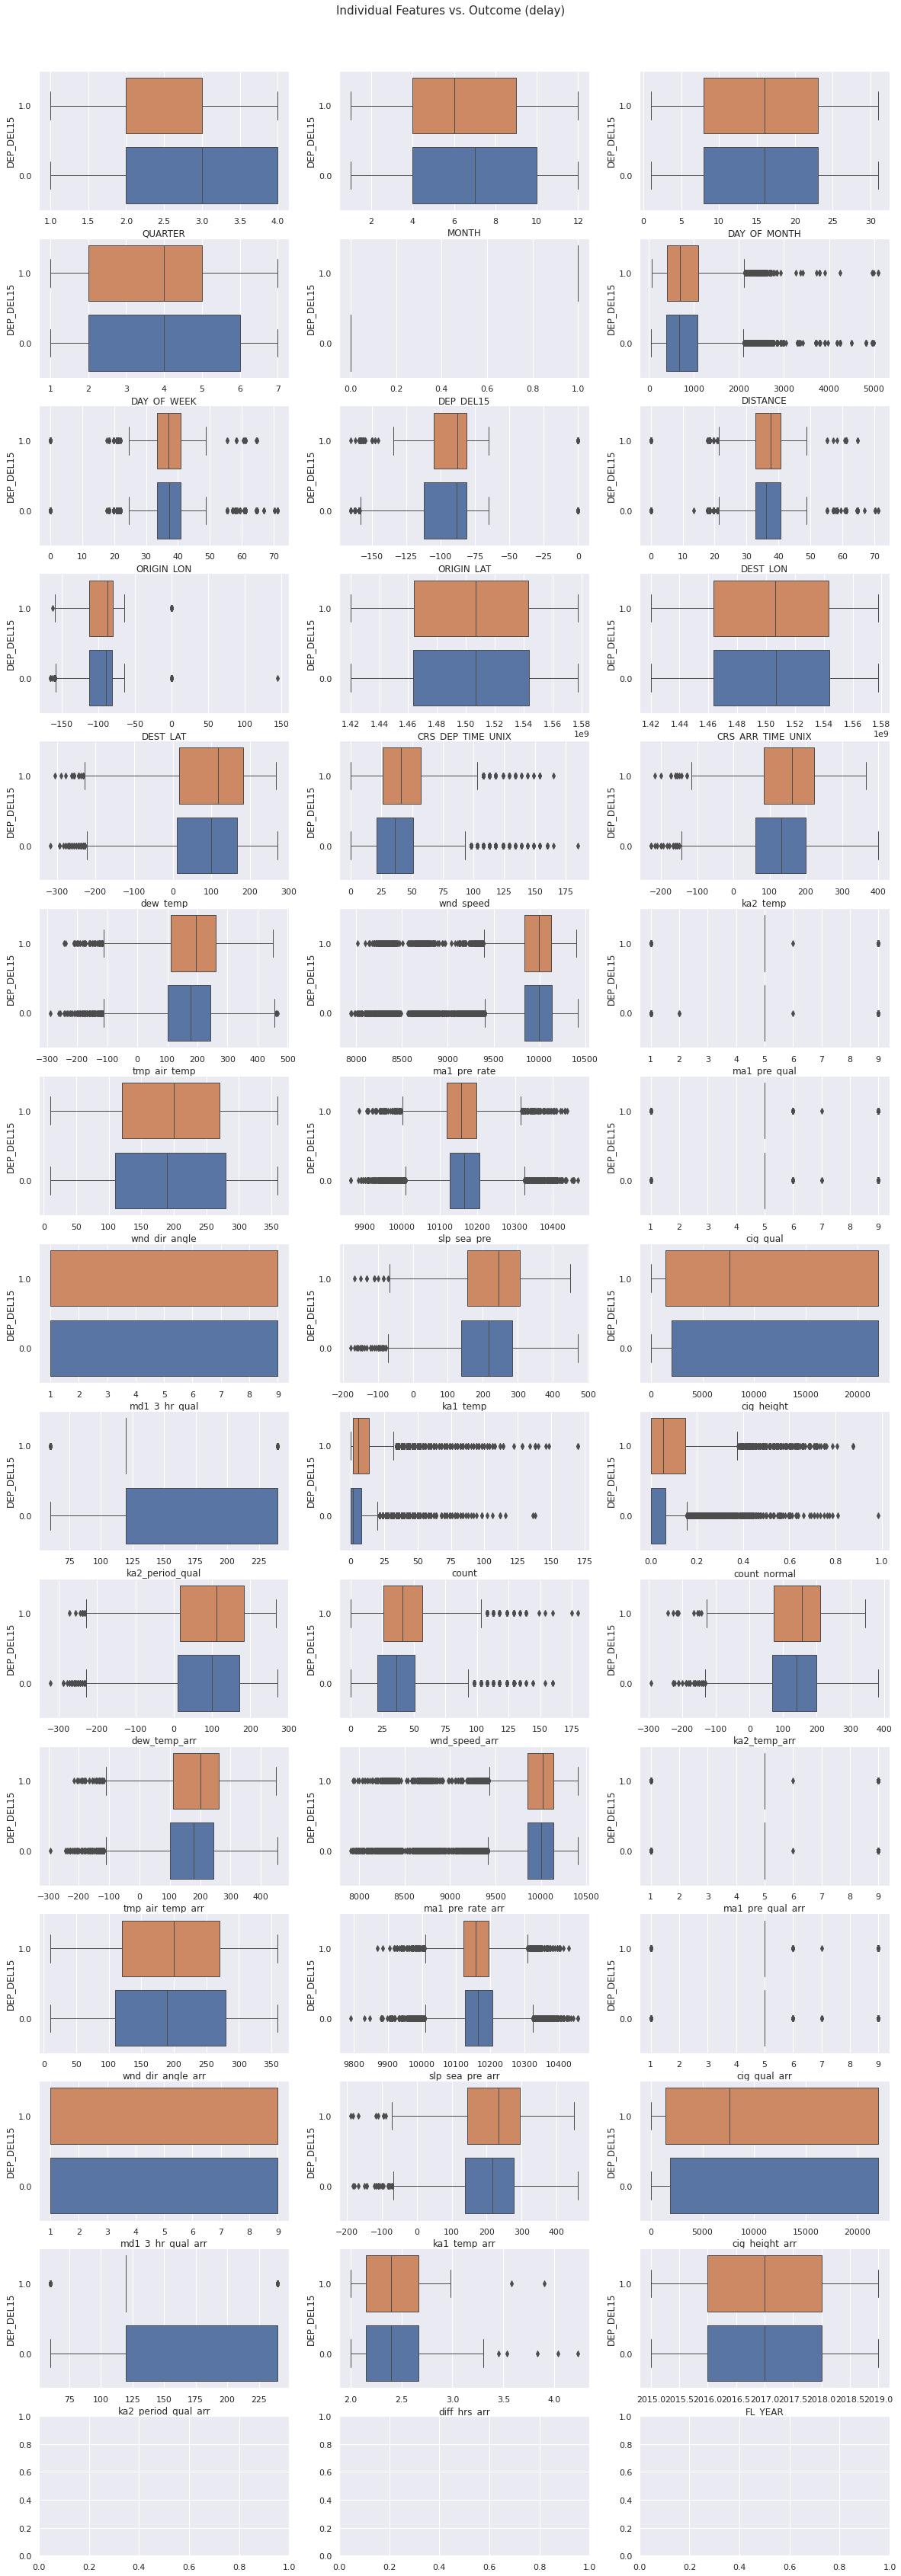

Text(0.5, 0.9, 'Individual Features vs. Outcome (delay)')

In [0]:
# Plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(15, 3, figsize=(20,60))
y = eda_hist_sam['DEP_DEL15']
for idx, feature in enumerate(FIELDS[:-1]):
    x = eda_hist_sam[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=1)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (delay)", fontsize=15, y=.9)
plt.show()

Surprisingly, there are noticable differences in the distributions of delay versus not-delayed with respect to quarter. In general, flights are more likely to be delayed in the first half of the year. Wind speed does seem to be higher for cancelled flights, which aligns with having that variable in the model.

### Correlation matrix

To start looking for model feature candidates, we created a correlation matrix of every numerical feature. We looked at both Pearson and Spearman correlation, but didn't end up finding any surprising features that were highly correlated to delay.

In [0]:
numeric_features = [t[0] for t in eda_hist.dtypes if (t[1] == 'int') | (t[1] == 'double')]

In [0]:
full_join_clean_numeric = eda_hist.select(numeric_features)

In [0]:
feature = full_join_clean_numeric.columns
feature

Out[390]: ['QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'DEP_DEL15',
 'DISTANCE',
 'ORIGIN_LON',
 'ORIGIN_LAT',
 'DEST_LON',
 'DEST_LAT',
 'CRS_DEP_TIME_UNIX',
 'CRS_ARR_TIME_UNIX',
 'dew_temp',
 'wnd_speed',
 'ka2_temp',
 'tmp_air_temp',
 'ma1_pre_rate',
 'ma1_pre_qual',
 'wnd_dir_angle',
 'slp_sea_pre',
 'cig_qual',
 'md1_3_hr_qual',
 'ka1_temp',
 'cig_height',
 'ka2_period_qual',
 'count',
 'count_normal',
 'dew_temp_arr',
 'wnd_speed_arr',
 'ka2_temp_arr',
 'tmp_air_temp_arr',
 'ma1_pre_rate_arr',
 'ma1_pre_qual_arr',
 'wnd_dir_angle_arr',
 'slp_sea_pre_arr',
 'cig_qual_arr',
 'md1_3_hr_qual_arr',
 'ka1_temp_arr',
 'cig_height_arr',
 'ka2_period_qual_arr',
 'diff_hrs_arr',
 'FL_YEAR',
 'PR_SCORE']

In [0]:
assembler = VectorAssembler(inputCols=feature, outputCol='features').setHandleInvalid("skip")
feature_vector = assembler.transform(eda_hist)


In [0]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(feature_vector.select('features'), 'features')
matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

#### Pearson Correlation matrix
Although the correlation matrix provides a great summary of how each feature correlates to the target DEP_DEL15, it only highlights a slight correlation with count. This is likely because the "Pearson" metric is designed for linear relationships and these features are not necessarily linearly related. Let's try "Spearman" next to see if there is any monotonic correlation.

Out[393]: Out[393]: Out[393]:

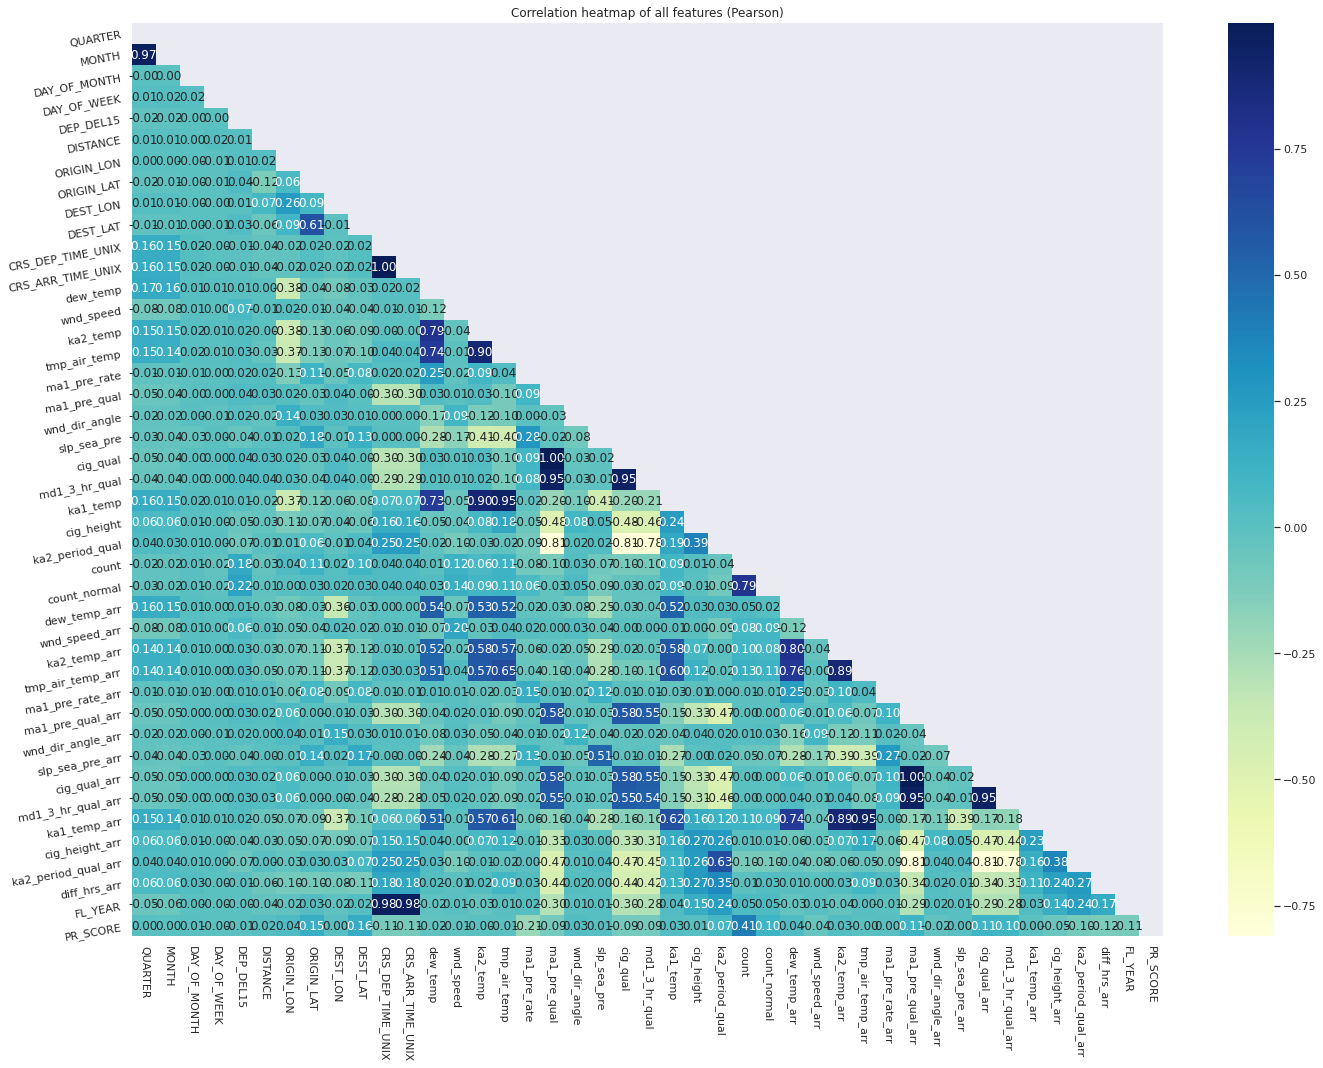

Text(0.5, 1.0, 'Correlation heatmap of all features (Pearson)')

In [0]:
matrix_np = matrix_np.reshape(len(feature),len(feature))
mask = np.triu(np.ones_like(matrix_np, dtype=bool))

fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix_np,mask=mask, cmap="YlGnBu",annot=True,fmt='.2f')
ax.xaxis.set_ticklabels(feature, rotation=270)
ax.yaxis.set_ticklabels(feature, rotation=10)
ax.set_title("Correlation heatmap of all features (Pearson)")
plt.tight_layout()
plt.show()

In [0]:
spearmanCorr = Correlation.corr(feature_vector, 'features', method='spearman').collect()[0][0]
print(str(spearmanCorr).replace('nan', 'NaN'))

DenseMatrix([[ 1.00000000e+00, 9.70089277e-01, -4.67687983e-04, ...,
 4.55667177e-02, -4.95233102e-02, -4.00813828e-03],
 [ 9.70089277e-01, 1.00000000e+00, 1.18107032e-03, ...,
 4.47587985e-02, -5.47645856e-02, -4.92024794e-03],
 [-4.67687983e-04, 1.18107032e-03, 1.00000000e+00, ...,
 1.34921177e-02, -5.07941418e-04, 7.91651277e-03],
 ...,
 [ 4.55667177e-02, 4.47587985e-02, 1.34921177e-02, ...,
 1.00000000e+00, 1.73380241e-01, -1.44592526e-01],
 [-4.95233102e-02, -5.47645856e-02, -5.07941418e-04, ...,
 1.73380241e-01, 1.00000000e+00, -7.49295875e-02],
 [-4.00813828e-03, -4.92024794e-03, 7.91651277e-03, ...,
 -1.44592526e-01, -7.49295875e-02, 1.00000000e+00]])

#### Spearman Correlation matrix
Unfortunately, Spearman correlation did not highlight any more features that could be beneficial to modeling. For due dilligence, we attemped a variance inflation factor analysis to identify multicollinearity, but were not able to successfully complete it. This would be something that we would try if we were to re-run this project. 

Reference: https://incipientanalyst.wordpress.com/2019/01/29/pyspark-code-for-variable-reduction-using-vif/

Out[395]: Out[395]: Out[395]:

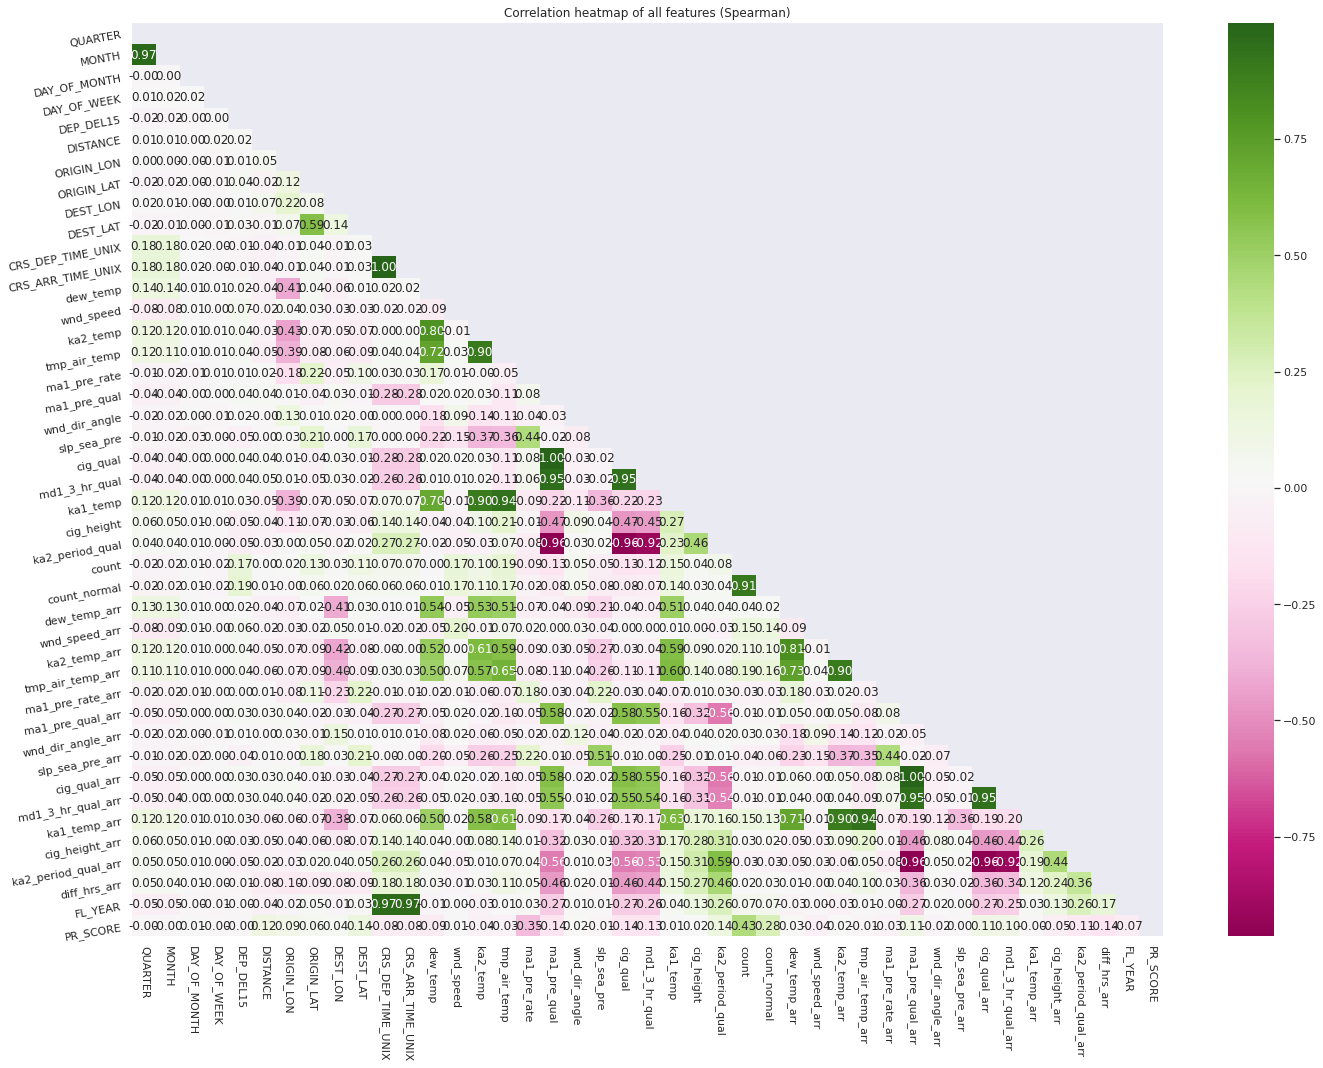

Text(0.5, 1.0, 'Correlation heatmap of all features (Spearman)')

In [0]:
matrix_spear = Correlation.corr(feature_vector.select('features'), 'features', method='spearman')
matrix_np_spear = matrix_spear.collect()[0]["spearman({})".format('features')].values
matrix_np_spear = matrix_np_spear.reshape(len(feature),len(feature))
mask = np.triu(np.ones_like(matrix_np_spear, dtype=bool))

fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(matrix_np_spear,mask=mask, cmap="PiYG",annot=True,fmt='.2f')
ax.xaxis.set_ticklabels(feature, rotation=270)
ax.yaxis.set_ticklabels(feature, rotation=10)
ax.set_title("Correlation heatmap of all features (Spearman)")
plt.tight_layout()
plt.show()